In [256]:
import sys 
sys.path.append('..')
from common.config import ConfigTrain as ct
from common.utils_train import sensors
from common.utils_train import header

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import warnings

#modeling part
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier


from scipy.stats import randint

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay

import shap

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format',  '{:,}'.format)



def read_in(file1, file2, file3, file4):
    df1 = pd.read_csv(file1, sep = " ", header = 0, names = header)
    df1['dataset'] = "FD001"
    df2 = pd.read_csv(file2, sep = " ", header = 0, names = header)
    df2['dataset'] = "FD002"
    df3 = pd.read_csv(file3, sep = " ", header = 0, names = header)
    df3['dataset'] = "FD003"
    df4 = pd.read_csv(file4, sep = " ", header = 0, names = header)
    df4['dataset'] = "FD004"
    return df1, df2, df3, df4

def concatenation(df1, df2, df3, df4):
    train = pd.concat([df1, df2, df3, df4], ignore_index=True)
    train = train.drop(["blank1", "blank2"], axis = 1)
    return train


def remining_cycles(train):
    maxi_df = pd.DataFrame(train.groupby(["esn", "dataset"])["cycles"].max().reset_index())
    maxi_df.rename(columns = {"cycles" : "max_cycles"}, inplace = True)
    train = train.merge(maxi_df, how = "left", on = ["esn", "dataset"])
    train['rul'] = train['cycles'] - train['max_cycles']
    return train

n_clusters = 6
def clustering(train):
    kmeans = KMeans(n_clusters = n_clusters, 
                    random_state = 0, 
                    n_init="auto").fit(train[["opset1","opset2"]].to_numpy())
    train["condition"] = kmeans.labels_
    return train

# lead time is a parameter to 
lead_time = -100
def make_y(row):
    """lead time is a parameter to be decided with what anticipation the business needs to know 
    about a failure to have enough time for action.
    100 cycles is a convenient anticipation

    This function creates Y_target value if ESN is less that 100 cycles to the Failure or more
    """
    return 1 if row["rul"] > lead_time else 0

def one_hot(df, column, names=None):
    enc = OneHotEncoder()
    labelenc = LabelEncoder()
    if names == None:
        names = df[column].unique().tolist()
    df['column_cat'] = labelenc.fit_transform(df[column])
    enc_df = pd.DataFrame(enc.fit_transform(df[column].to_numpy().reshape(-1,1)).toarray(), columns = names)
    enc_df.drop(columns = names[0], inplace = True)
    df = pd.concat([df, enc_df], axis = 1)
    df.drop(columns = column, inplace = True)
    df.drop(columns = 'column_cat', inplace = True)
    return df

In [257]:
df1, df2, df3, df4 = read_in(ct.location1, ct.location2, ct.location3, ct.location4)

In [258]:
train = concatenation(df1, df2, df3, df4)
train = remining_cycles(train)
train = clustering(train)


In [259]:
train.head()

esn  cycles  opset1  opset2   TRA     T2    T24      T30      T50    P2  \
0    1       2  0.0019 -0.0003 100.0 518.67 642.15 1,591.82 1,403.14 14.62   
1    1       3 -0.0043  0.0003 100.0 518.67 642.35 1,587.99  1,404.2 14.62   
2    1       4  0.0007     0.0 100.0 518.67 642.35 1,582.79 1,401.87 14.62   
3    1       5 -0.0019 -0.0002 100.0 518.67 642.37 1,582.85 1,406.22 14.62   
4    1       6 -0.0043 -0.0001 100.0 518.67  642.1 1,584.47 1,398.37 14.62   

    P15    P30       Nf       Nc  epr  Ps30    phi      NRf      NRc    BPR  \
0 21.61 553.75 2,388.04 9,044.07  1.3 47.49 522.28 2,388.07 8,131.49 8.4318   
1 21.61 554.26 2,388.08 9,052.94  1.3 47.27 522.42 2,388.03 8,133.23 8.4178   
2 21.61 554.45 2,388.11 9,049.48  1.3 47.13 522.86 2,388.08 8,133.83 8.3682   
3 21.61  554.0 2,388.06 9,055.15  1.3 47.28 522.19 2,388.04  8,133.8 8.4294   
4 21.61 554.67 2,388.02 9,049.68  1.3 47.16 521.68 2,388.03 8,132.85 8.4108   

   farB  htBleed  Nf_dmd  PCNfR_dmd   W31     W32 dataset  max_cycles  rul  \
0  0.03      392    2388      100.0  39.0 23.4236   FD001         192 -190   
1  0.03      390    2388      100.0 38.95 23.3442   FD001         192 -189   
2  0.03      392    2388      100.0 38.88 23.3739   FD001         192 -188   
3  0.03      393    2388      100.0  38.9 23.4044   FD001         192 -187   
4  0.03      391    2388      100.0 38.98 23.3669   FD001         192 -186   

   condition  
0          2  
1          2  
2          2  
3          2  
4          2

# Diagnostics

As business requirement is to know prior 100 cycles which ESN will be damaged, variable y_train ["Class"] is created where **1**: ESN is damaged, **0**: ESN is not damaged.

Classification model is to be train having y_train and only sensors and condition variables as X_train

Classification model is going to be tested aganist validation set retrieved from train set

In [260]:
def make_y(row):
    return 1 if row["rul"] > lead_time else 0

train["Class"] = train.apply(make_y, axis = 1)

In [261]:
train.head()

esn  cycles  opset1  opset2   TRA     T2    T24      T30      T50    P2  \
0    1       2  0.0019 -0.0003 100.0 518.67 642.15 1,591.82 1,403.14 14.62   
1    1       3 -0.0043  0.0003 100.0 518.67 642.35 1,587.99  1,404.2 14.62   
2    1       4  0.0007     0.0 100.0 518.67 642.35 1,582.79 1,401.87 14.62   
3    1       5 -0.0019 -0.0002 100.0 518.67 642.37 1,582.85 1,406.22 14.62   
4    1       6 -0.0043 -0.0001 100.0 518.67  642.1 1,584.47 1,398.37 14.62   

    P15    P30       Nf       Nc  epr  Ps30    phi      NRf      NRc    BPR  \
0 21.61 553.75 2,388.04 9,044.07  1.3 47.49 522.28 2,388.07 8,131.49 8.4318   
1 21.61 554.26 2,388.08 9,052.94  1.3 47.27 522.42 2,388.03 8,133.23 8.4178   
2 21.61 554.45 2,388.11 9,049.48  1.3 47.13 522.86 2,388.08 8,133.83 8.3682   
3 21.61  554.0 2,388.06 9,055.15  1.3 47.28 522.19 2,388.04  8,133.8 8.4294   
4 21.61 554.67 2,388.02 9,049.68  1.3 47.16 521.68 2,388.03 8,132.85 8.4108   

   farB  htBleed  Nf_dmd  PCNfR_dmd   W31     W32 dataset  max_cycles  rul  \
0  0.03      392    2388      100.0  39.0 23.4236   FD001         192 -190   
1  0.03      390    2388      100.0 38.95 23.3442   FD001         192 -189   
2  0.03      392    2388      100.0 38.88 23.3739   FD001         192 -188   
3  0.03      393    2388      100.0  38.9 23.4044   FD001         192 -187   
4  0.03      391    2388      100.0 38.98 23.3669   FD001         192 -186   

   condition  Class  
0          2      0  
1          2      0  
2          2      0  
3          2      0  
4          2      0

## Data Visualisation and Feature Selection

On basis of following visualization, sensors that are not vary will be excluded from list of predictors.
List of final predictors:
1. T24
2. T30 aka T3
3. T50
4. P30 aka P3
5. Nc
6. epr
7. Ps30
8. phi
9. NRc
10. BPR
11. htBleed
12. W31
13. W32
14. condition
15. dataset

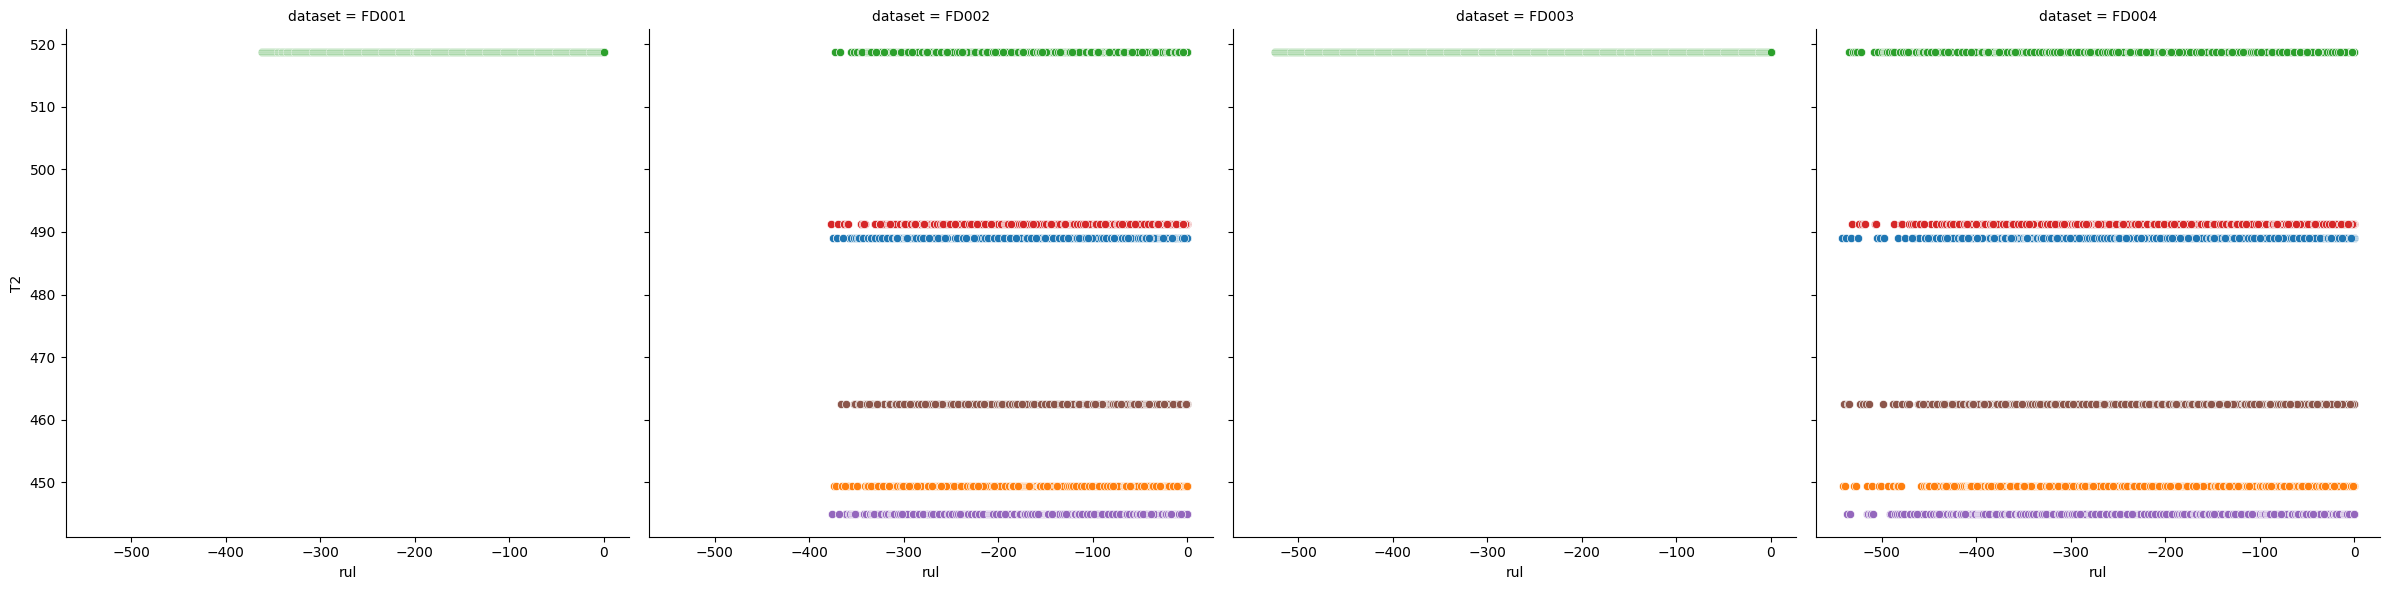

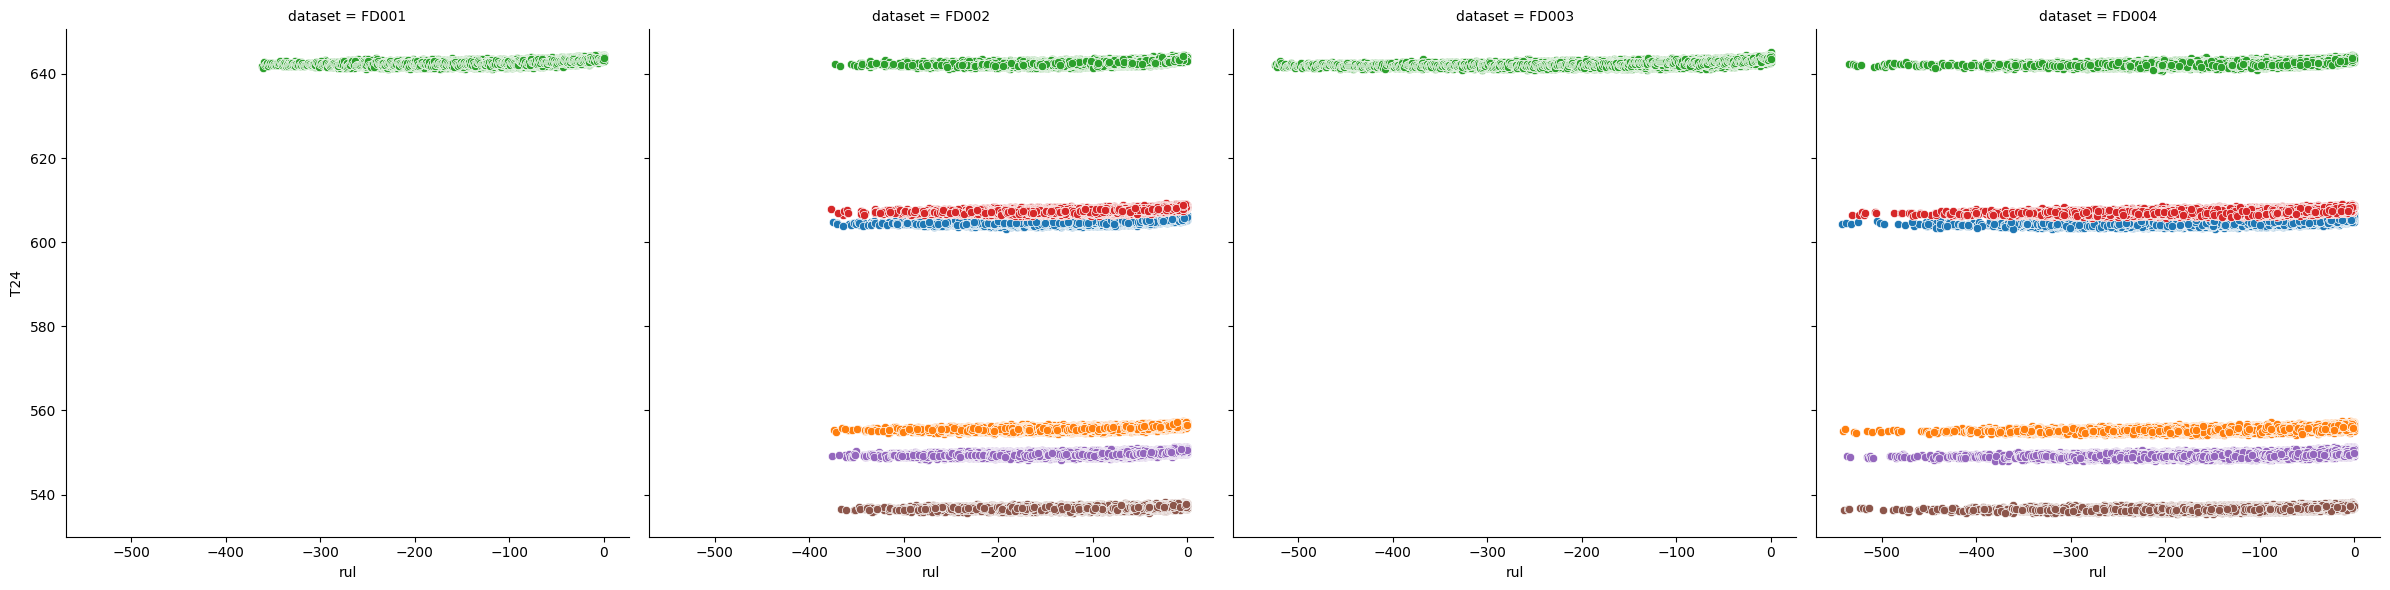

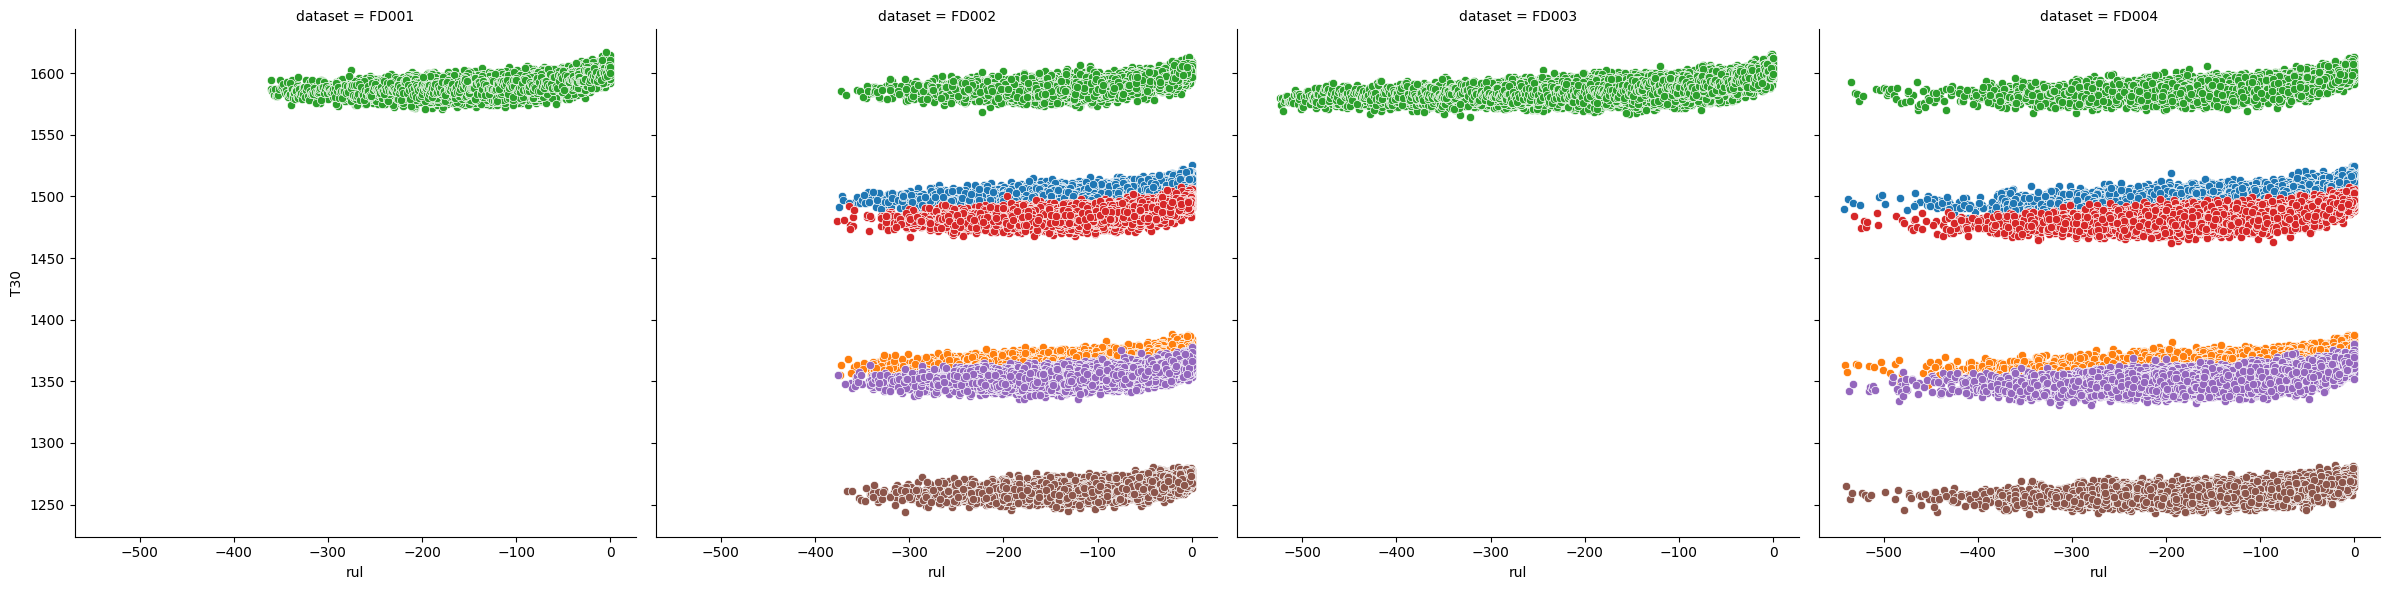

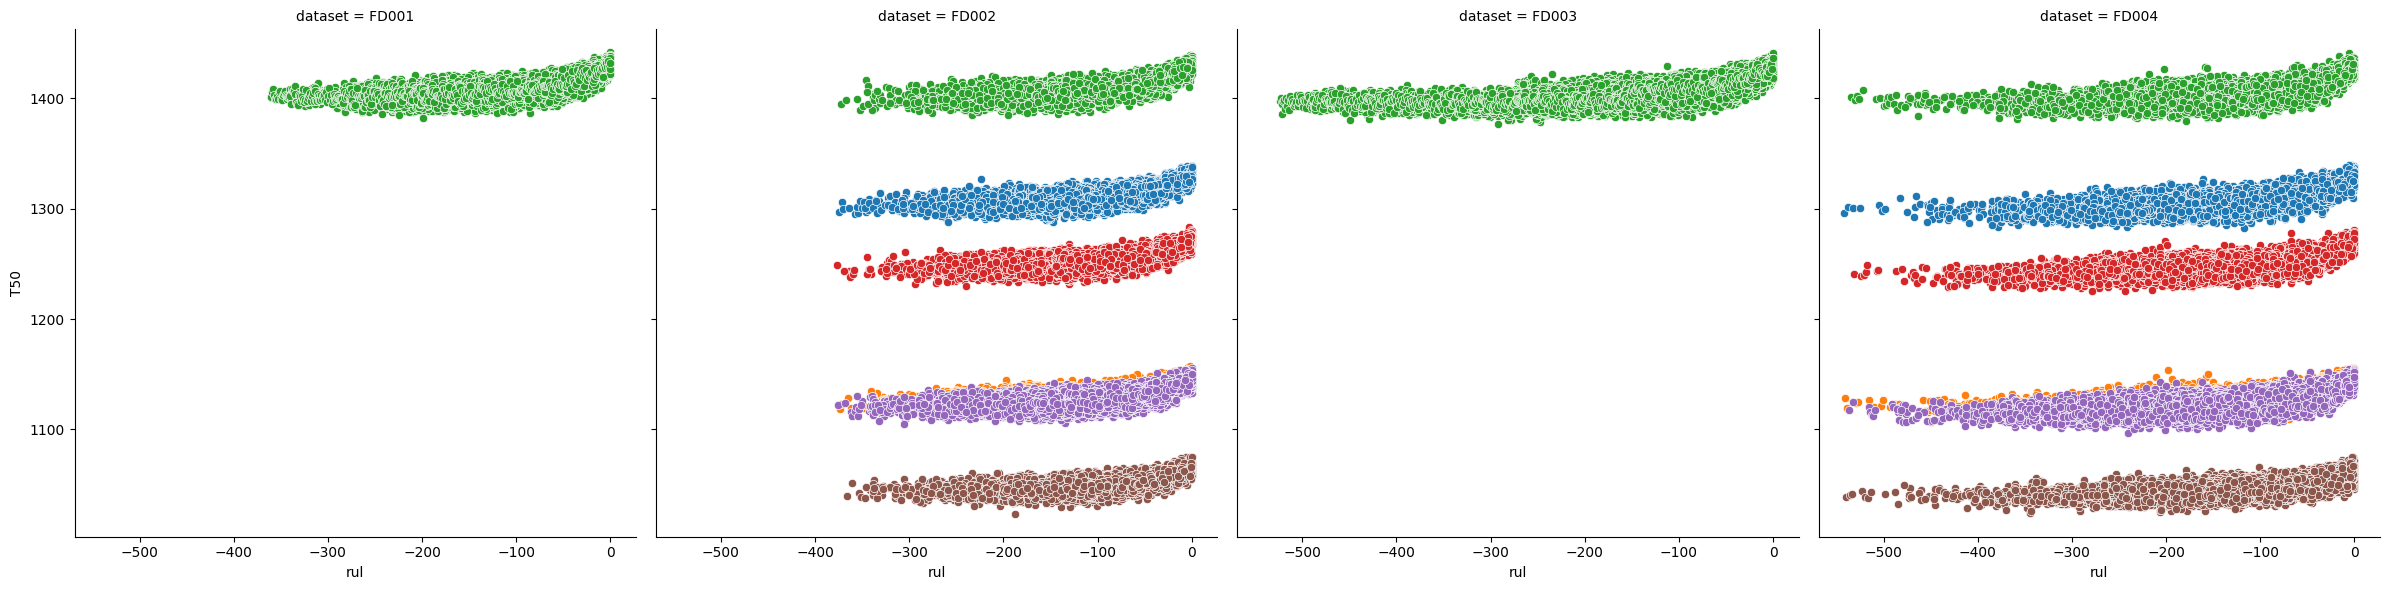

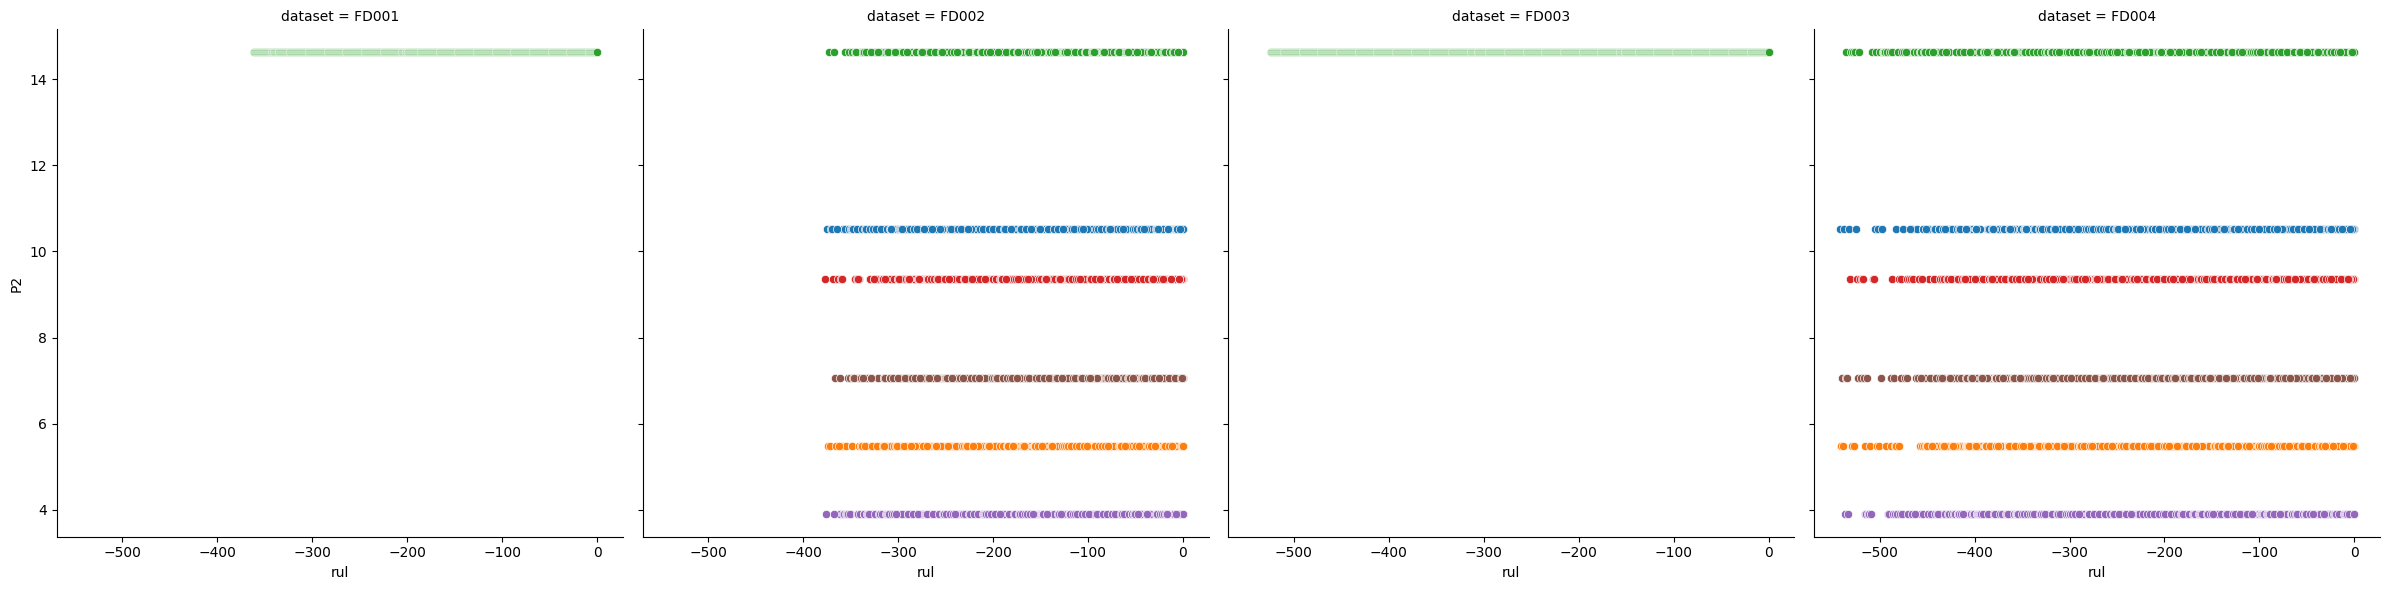

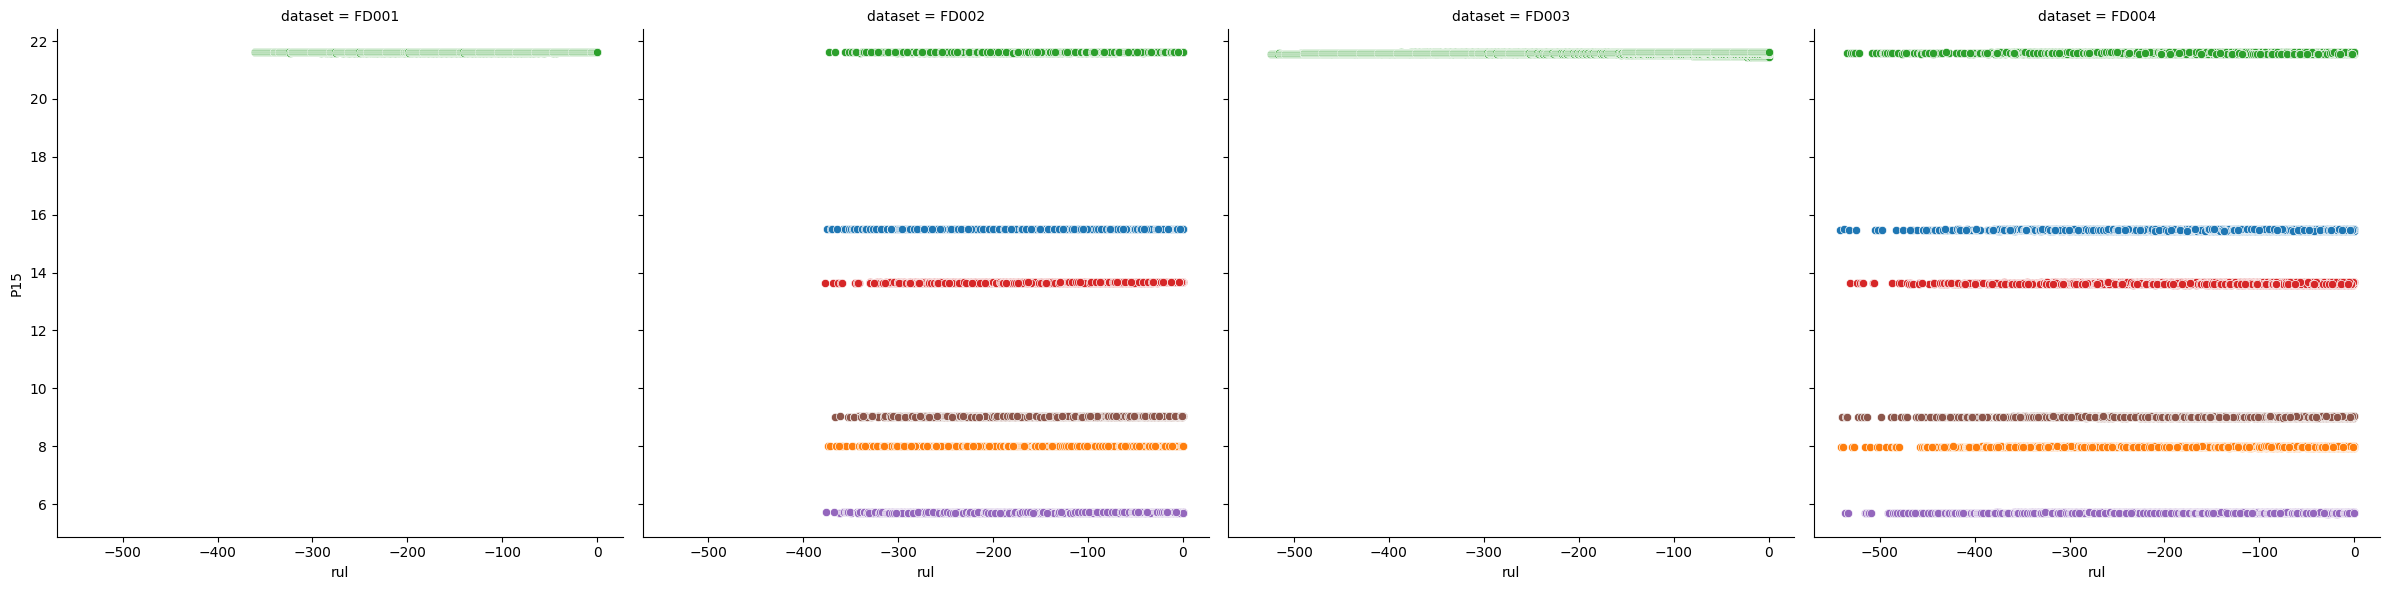

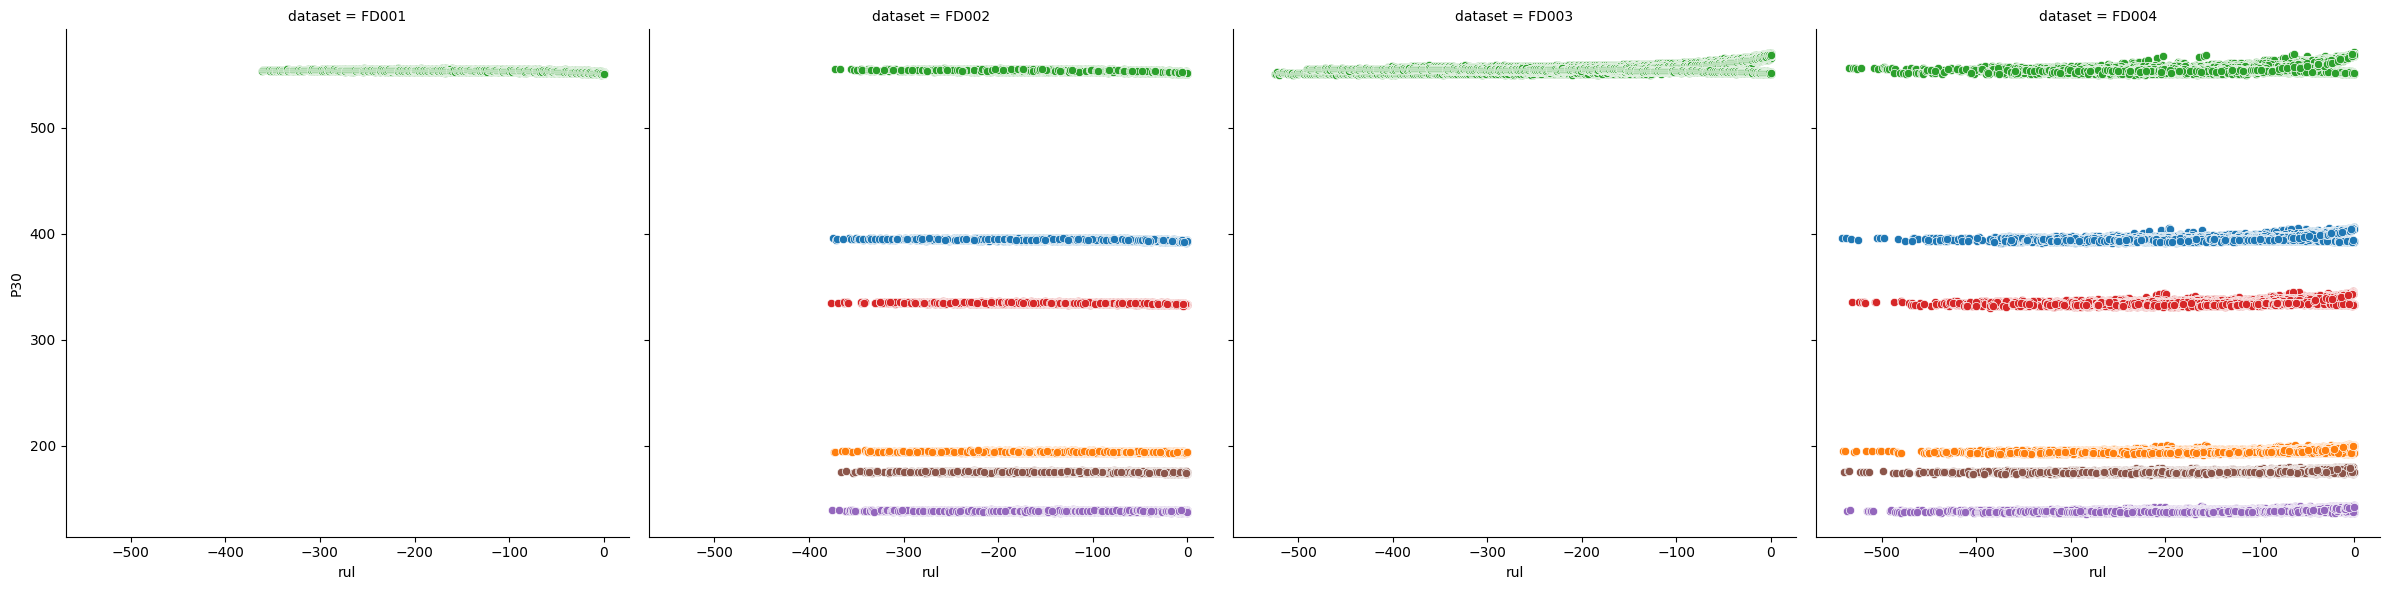

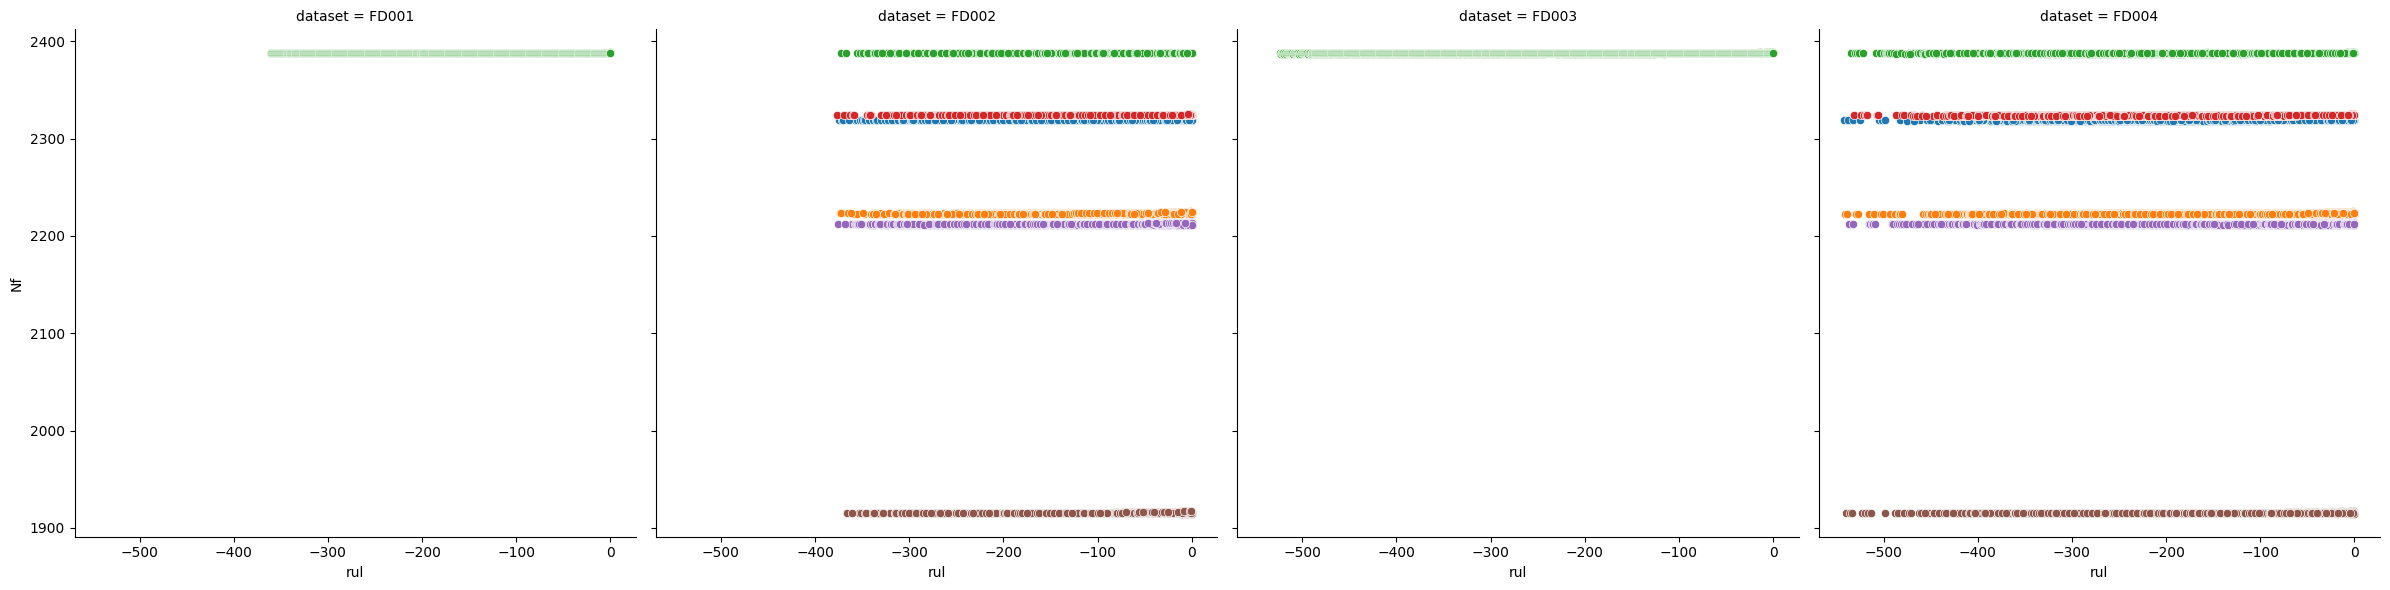

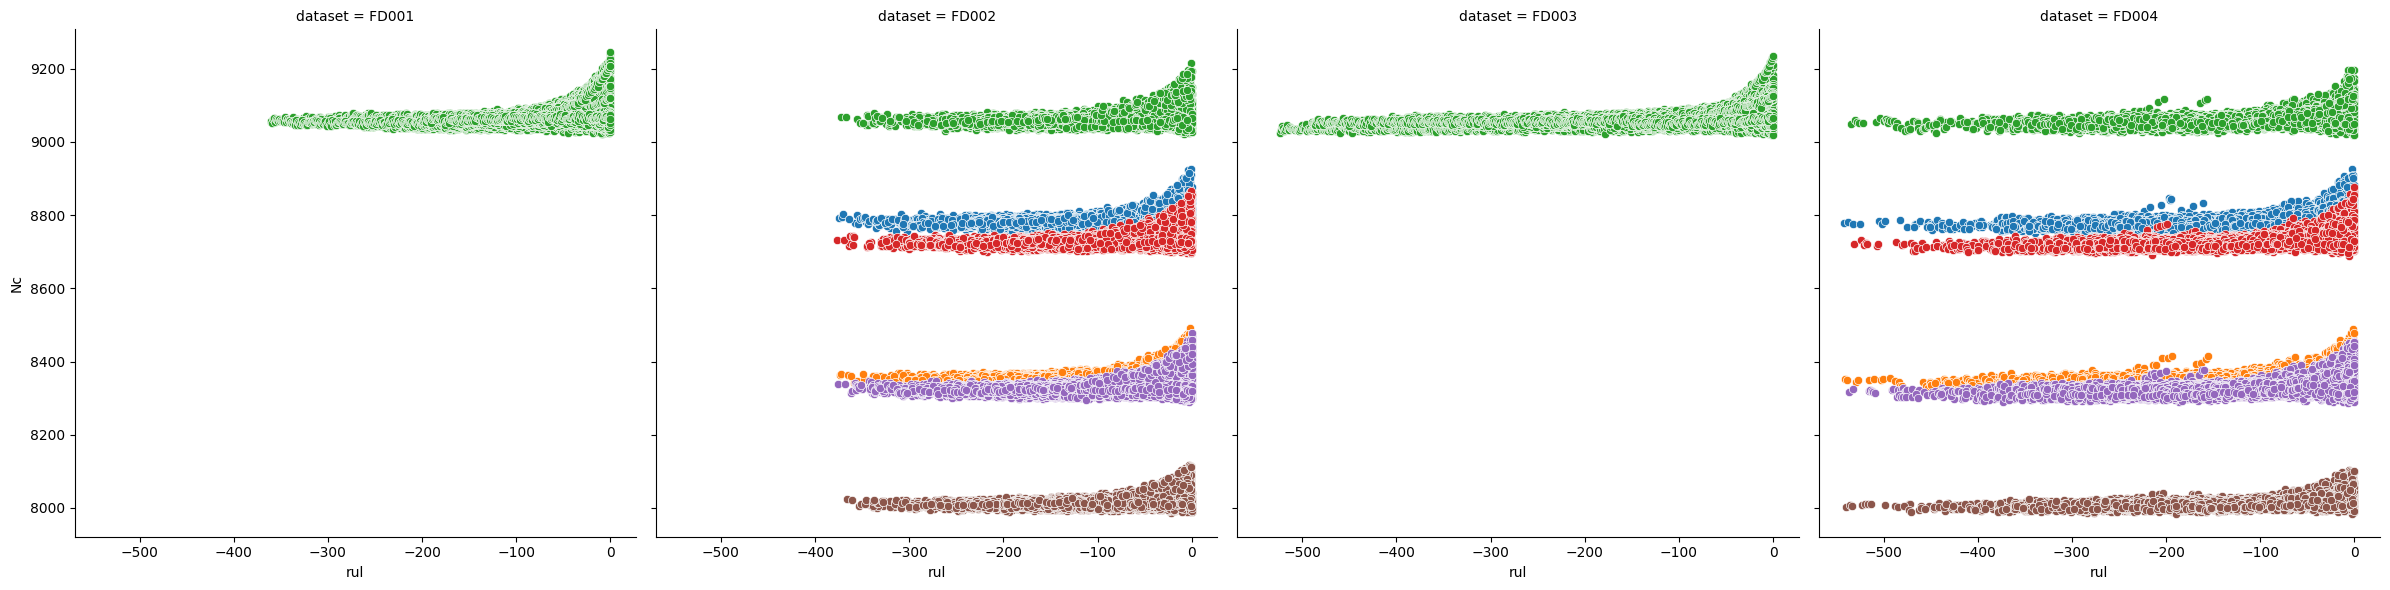

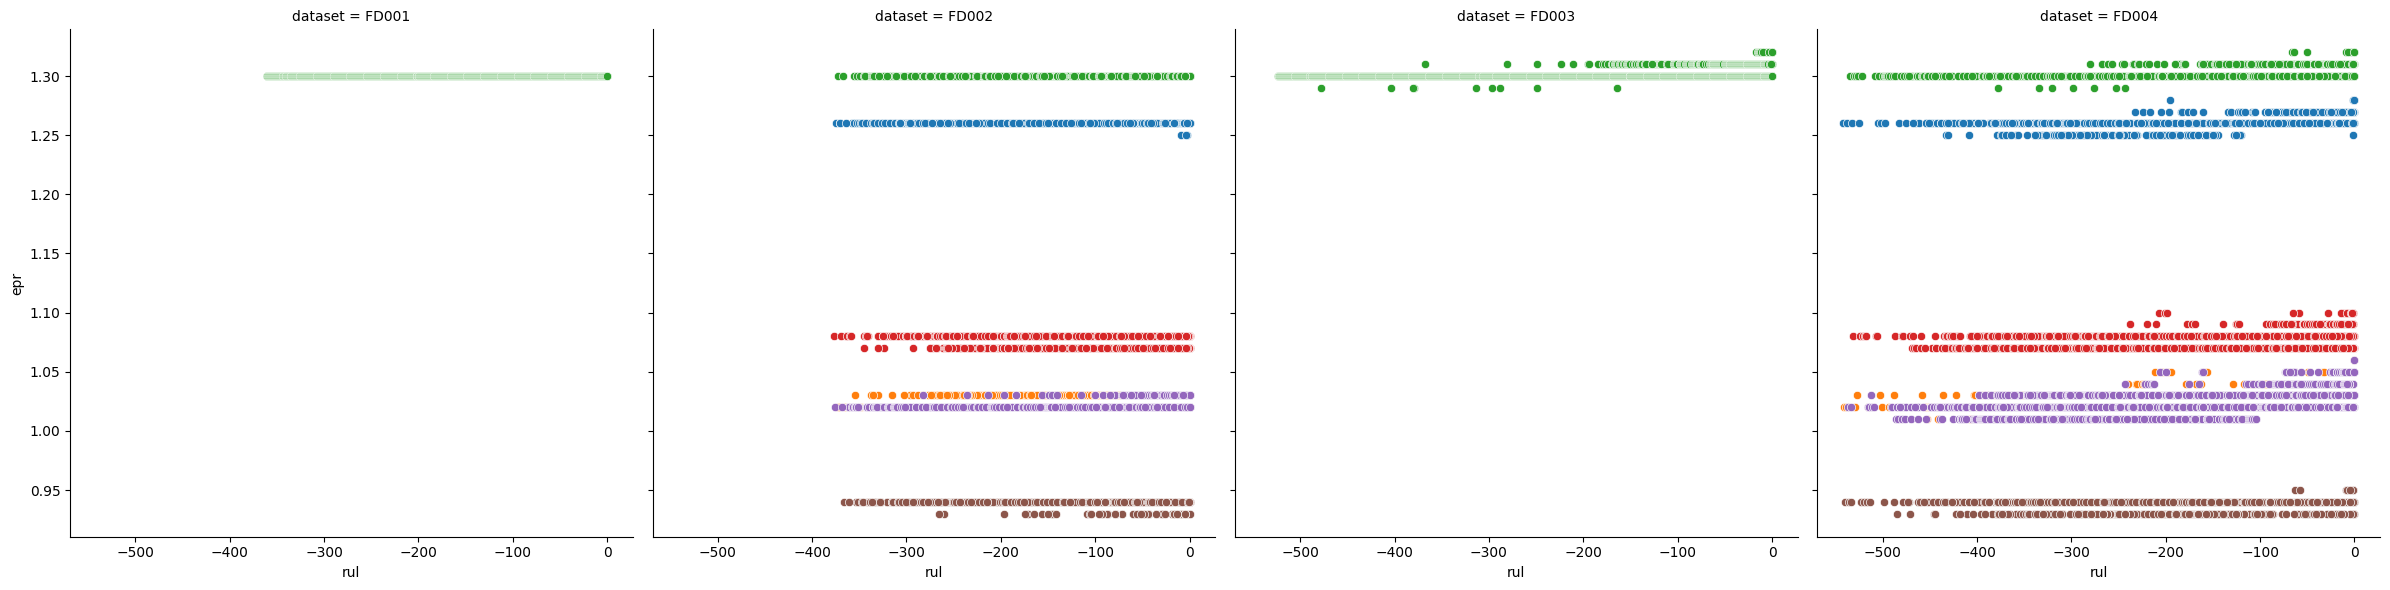

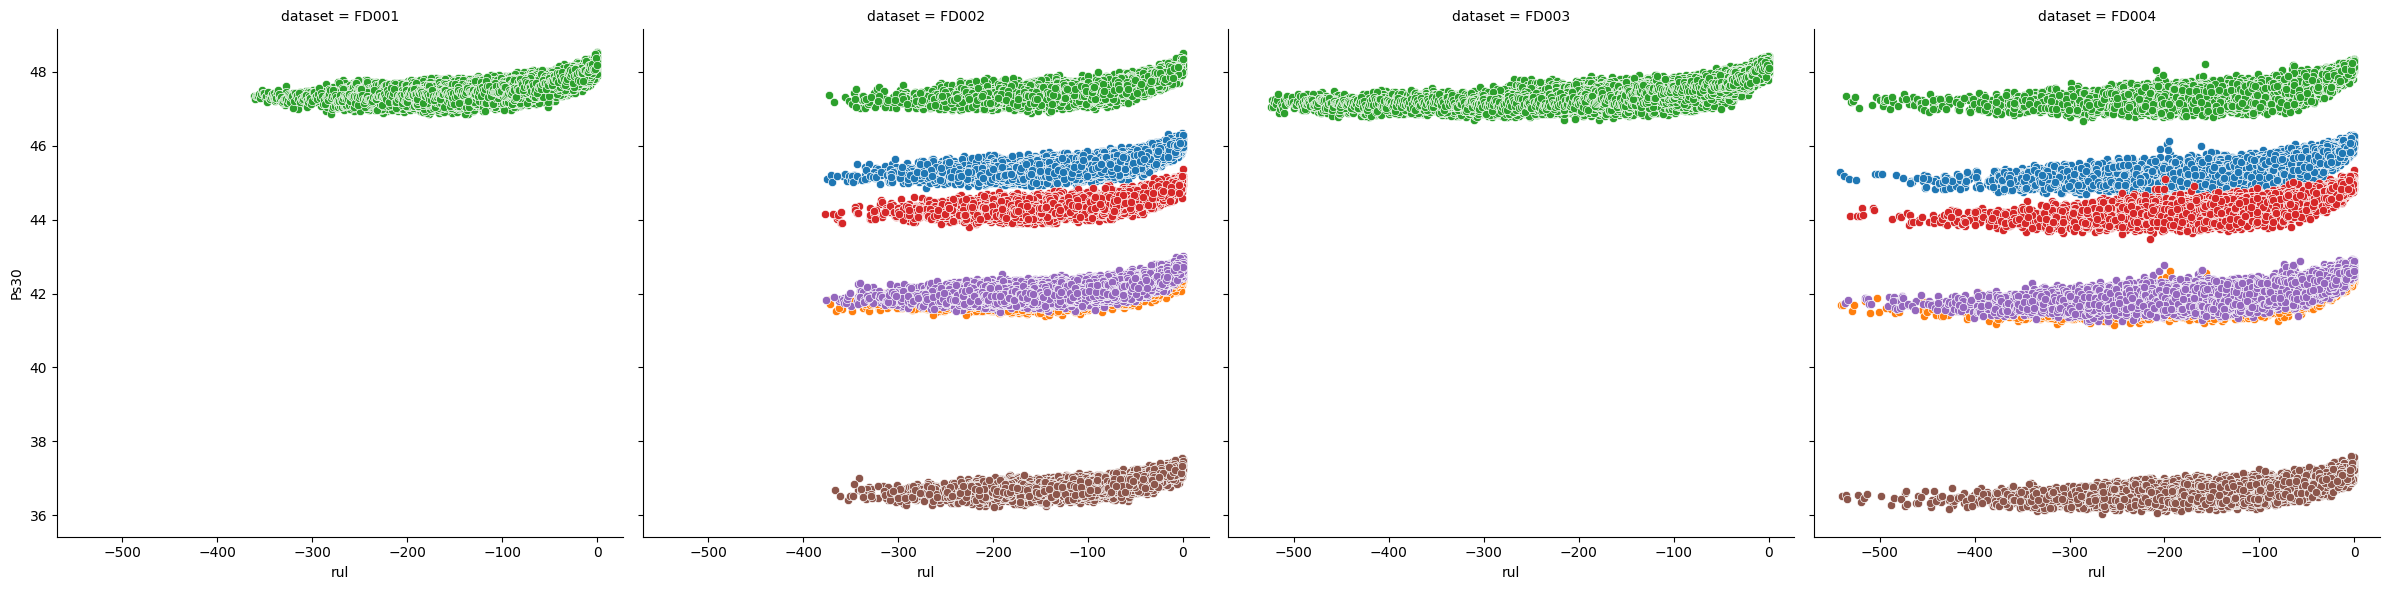

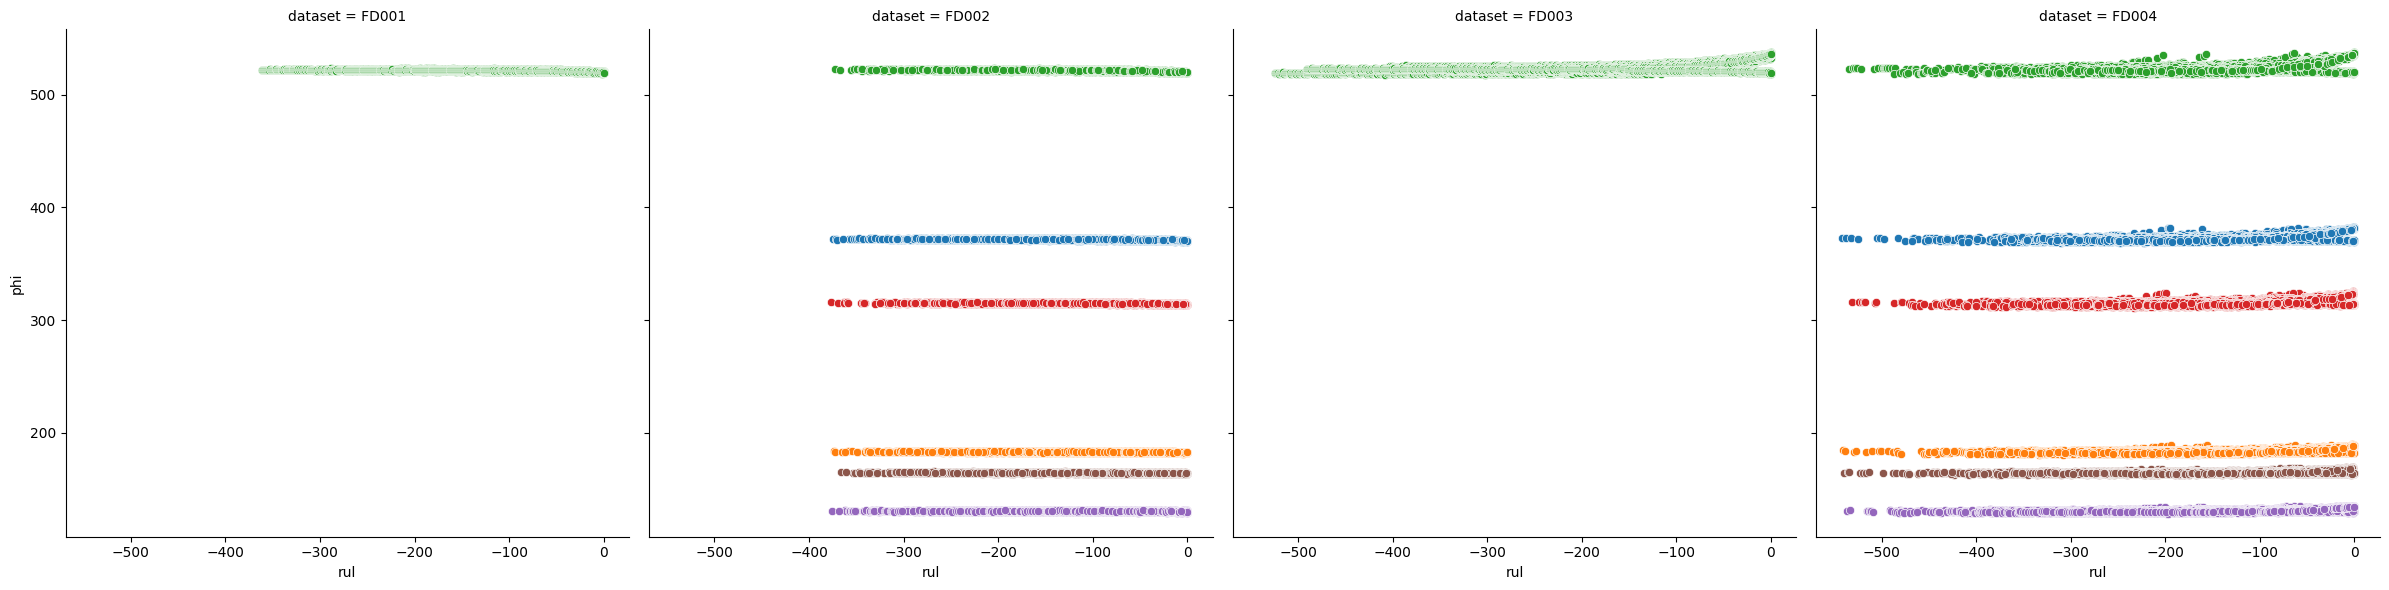

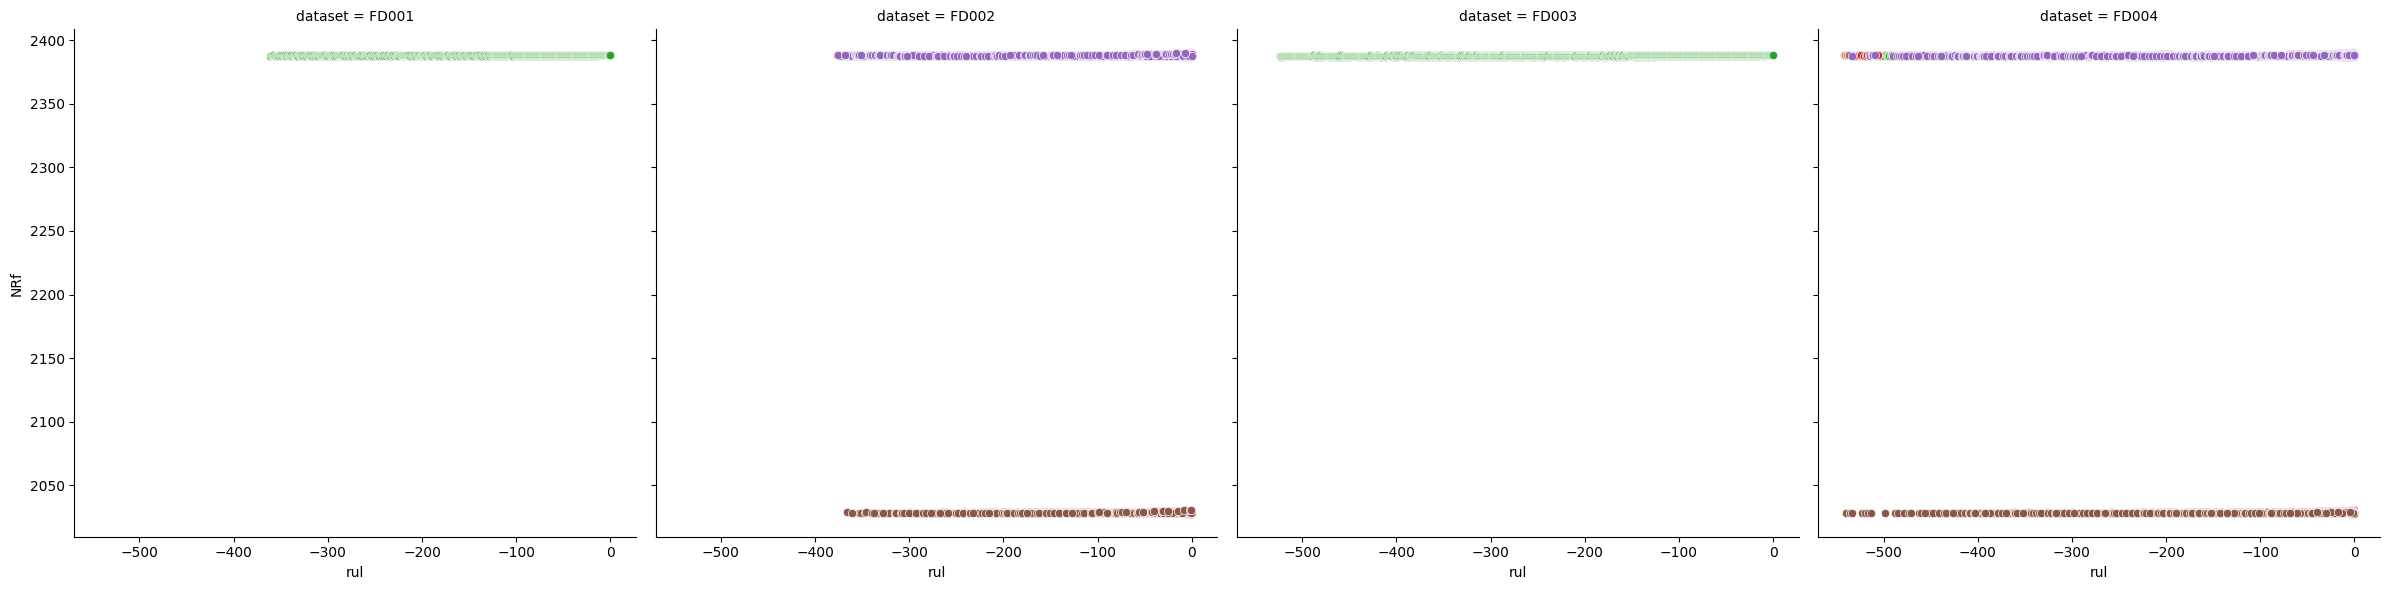

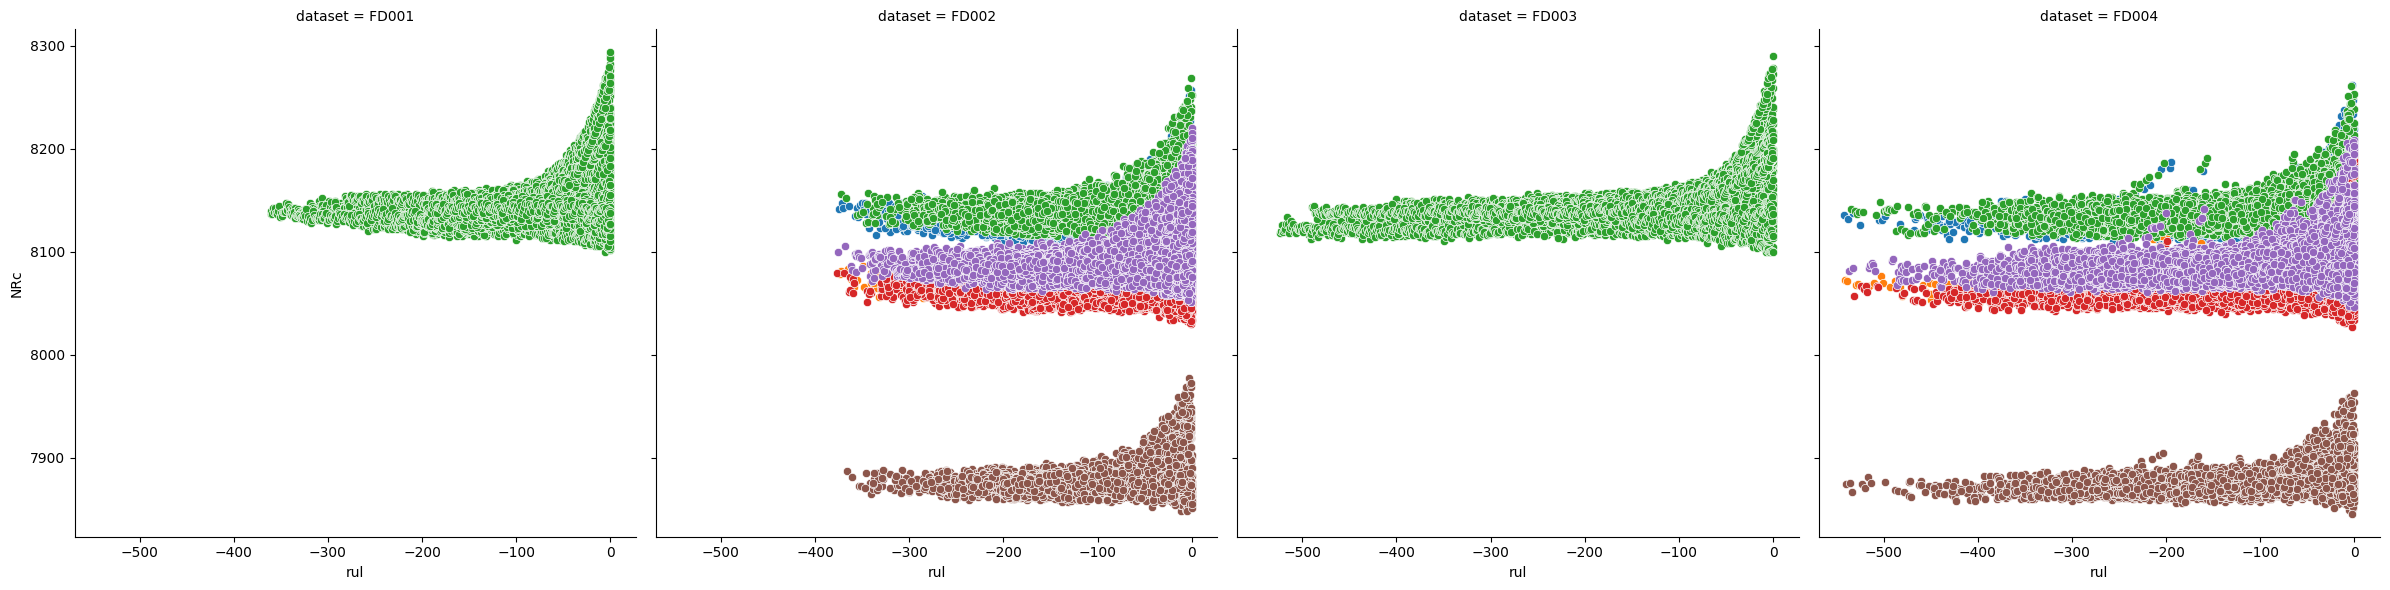

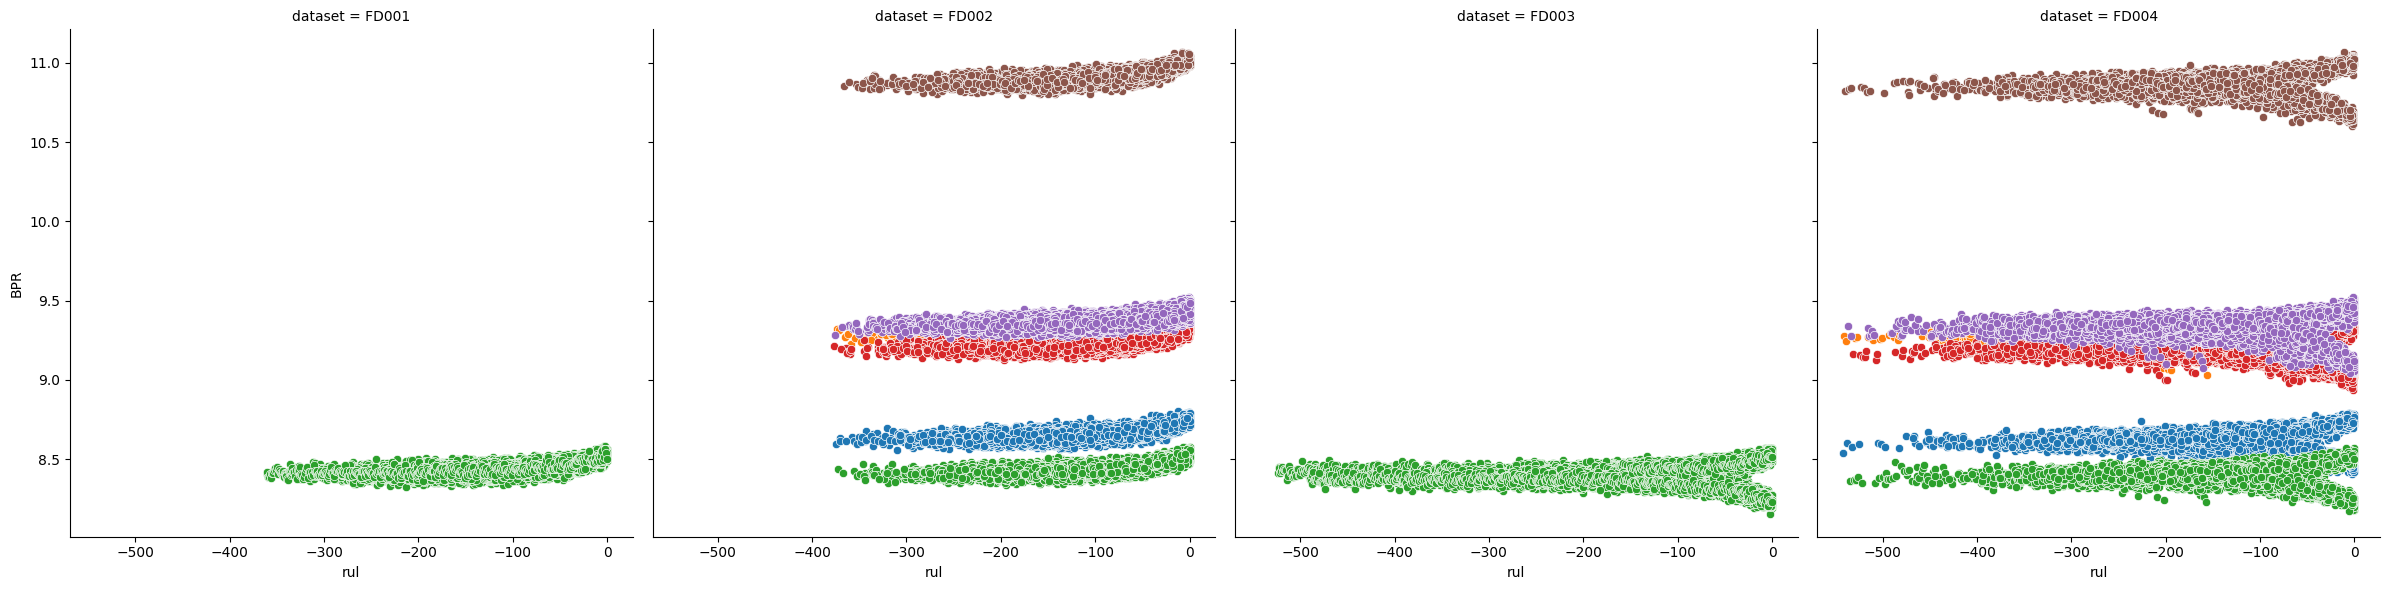

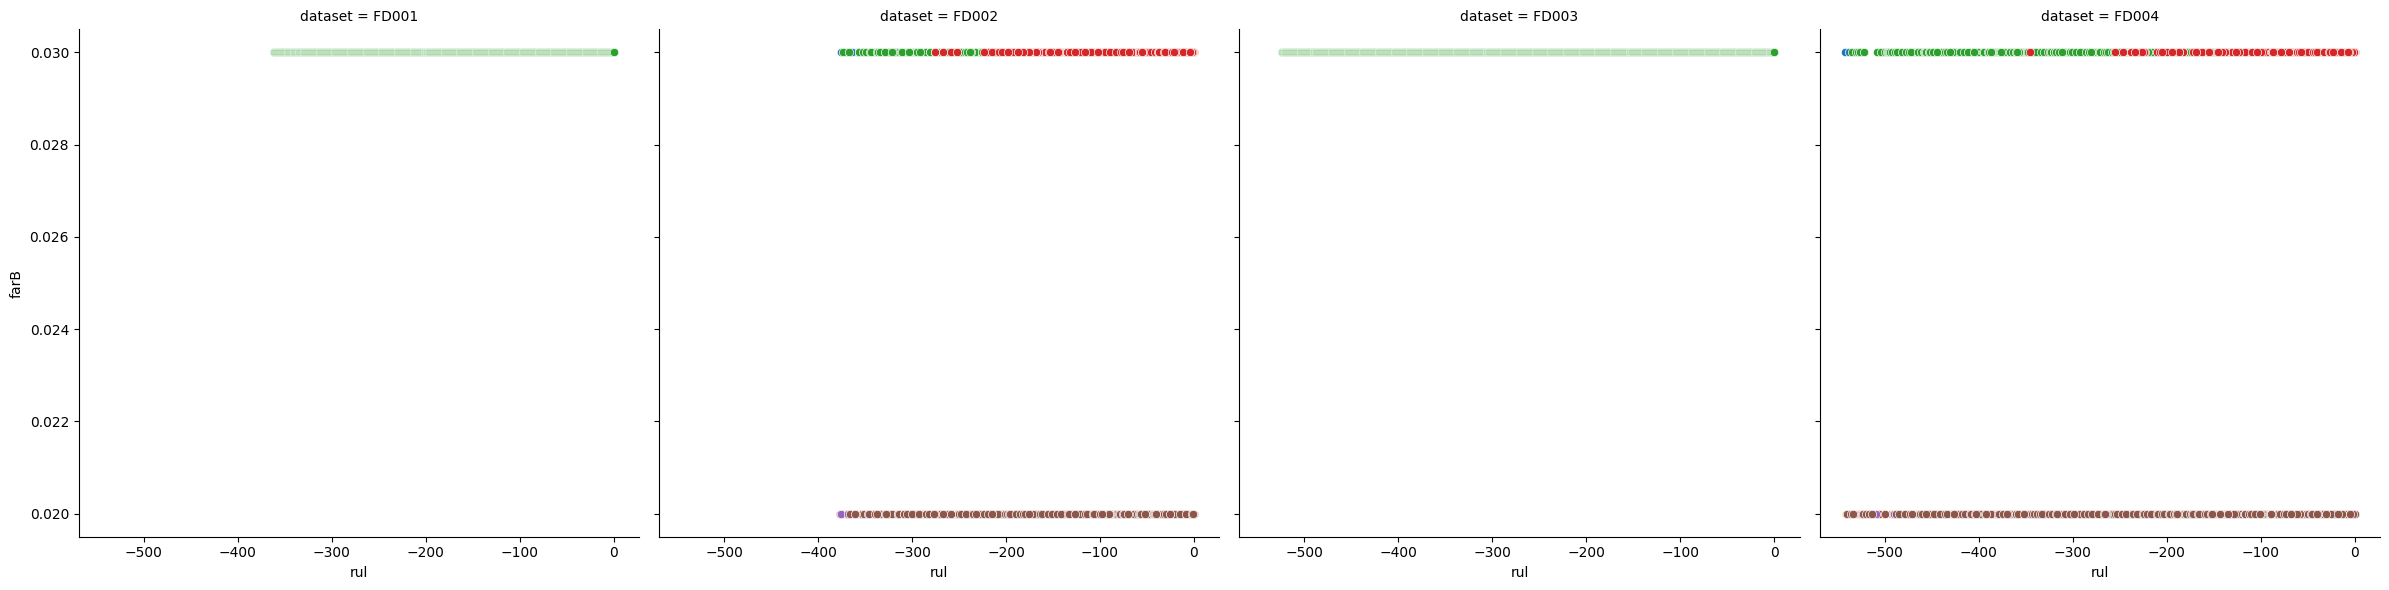

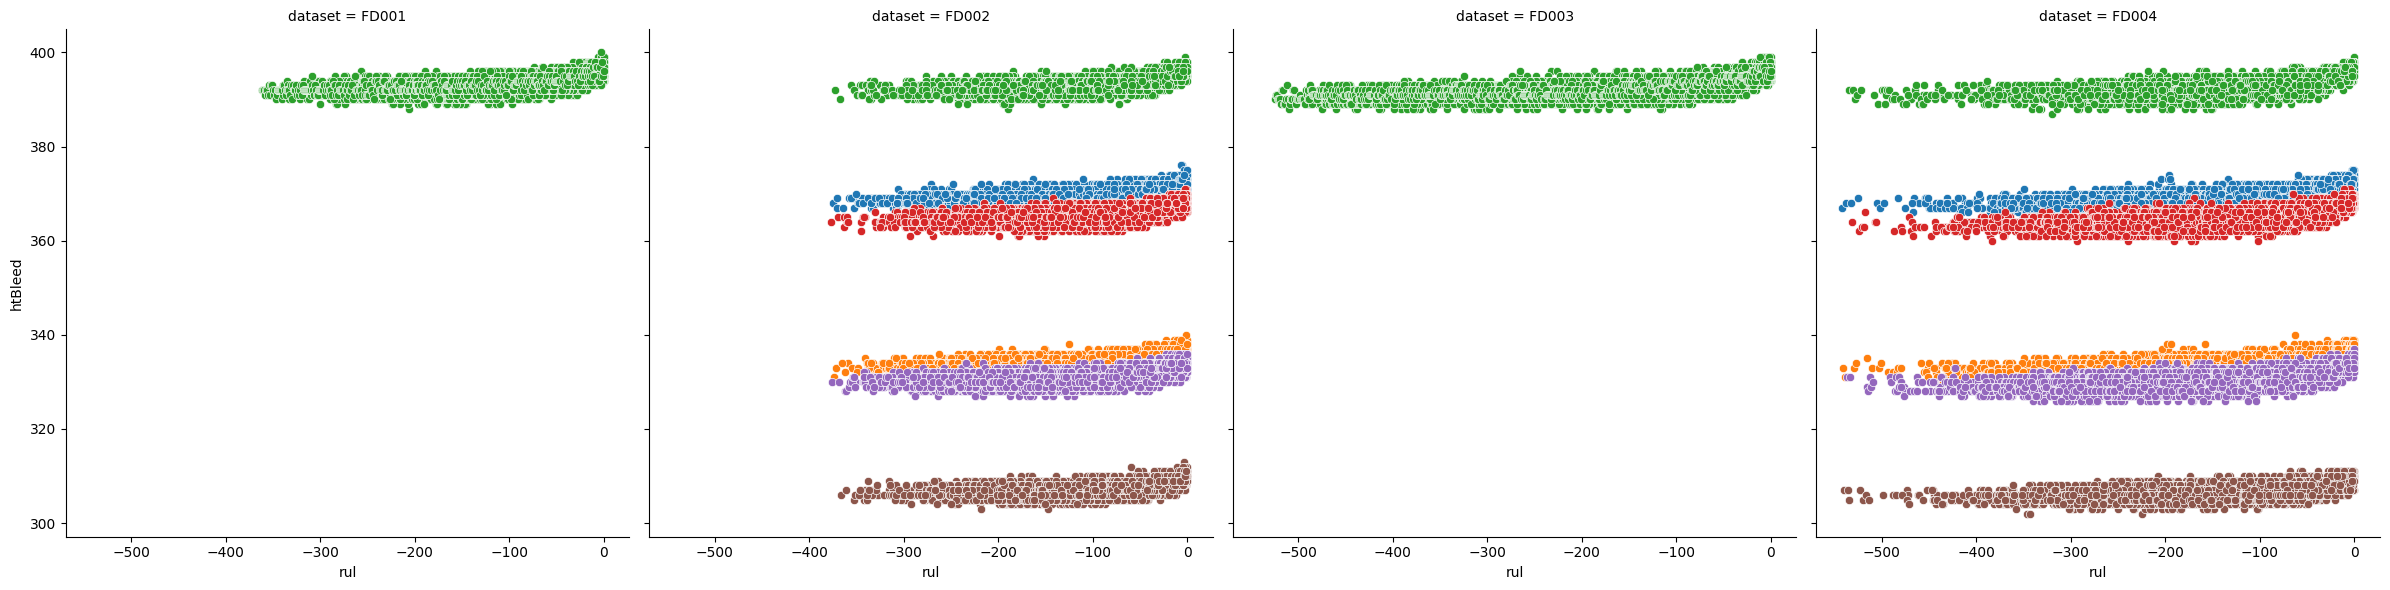

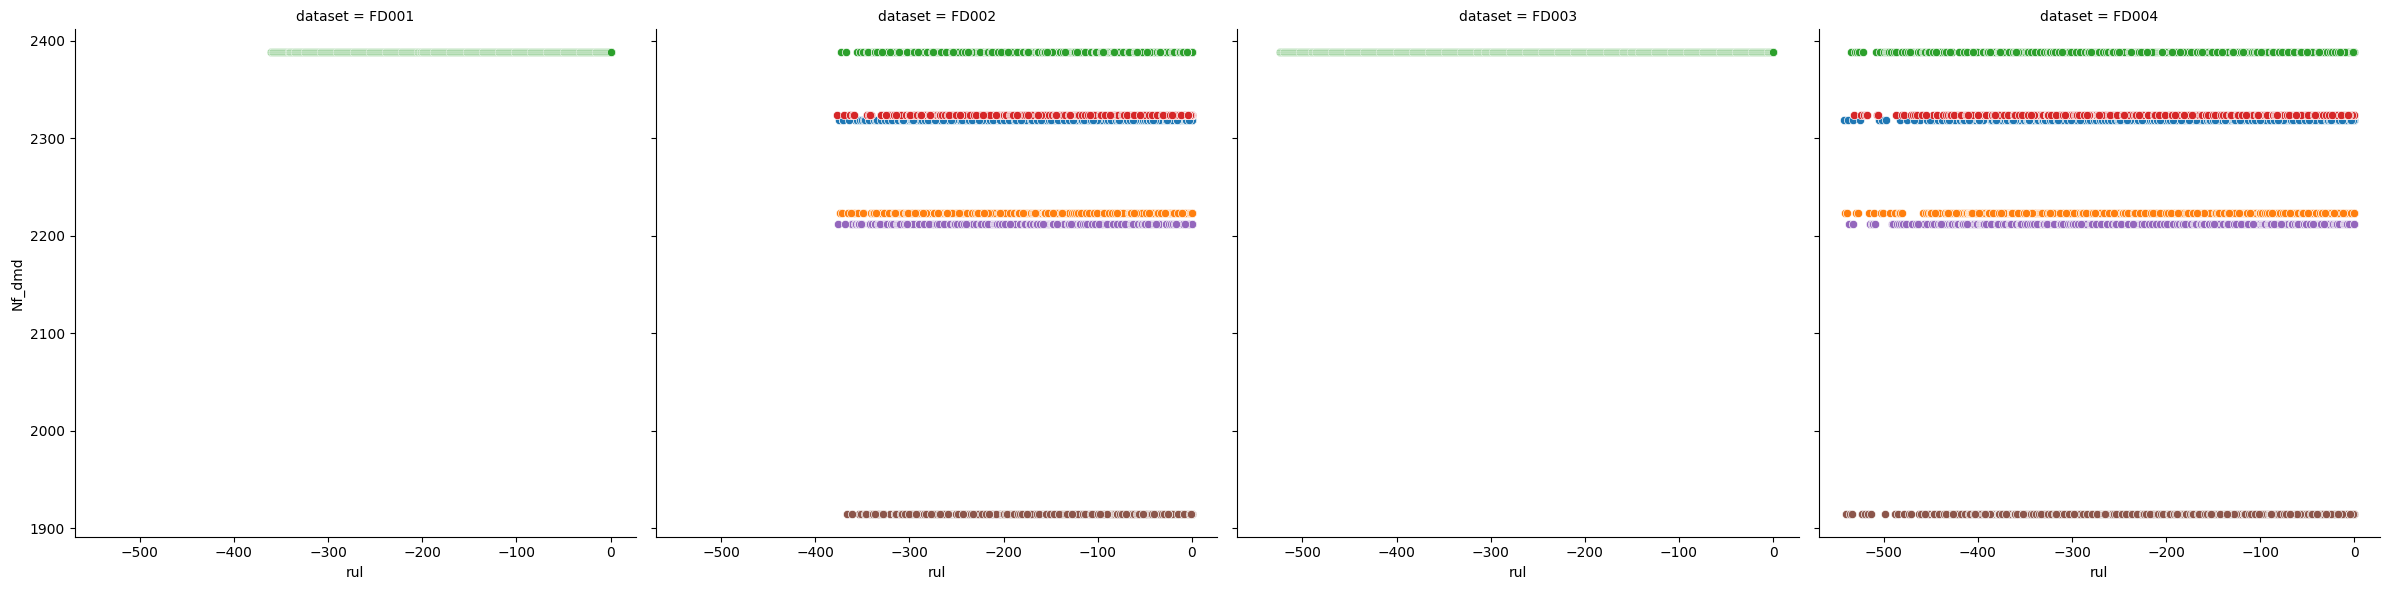

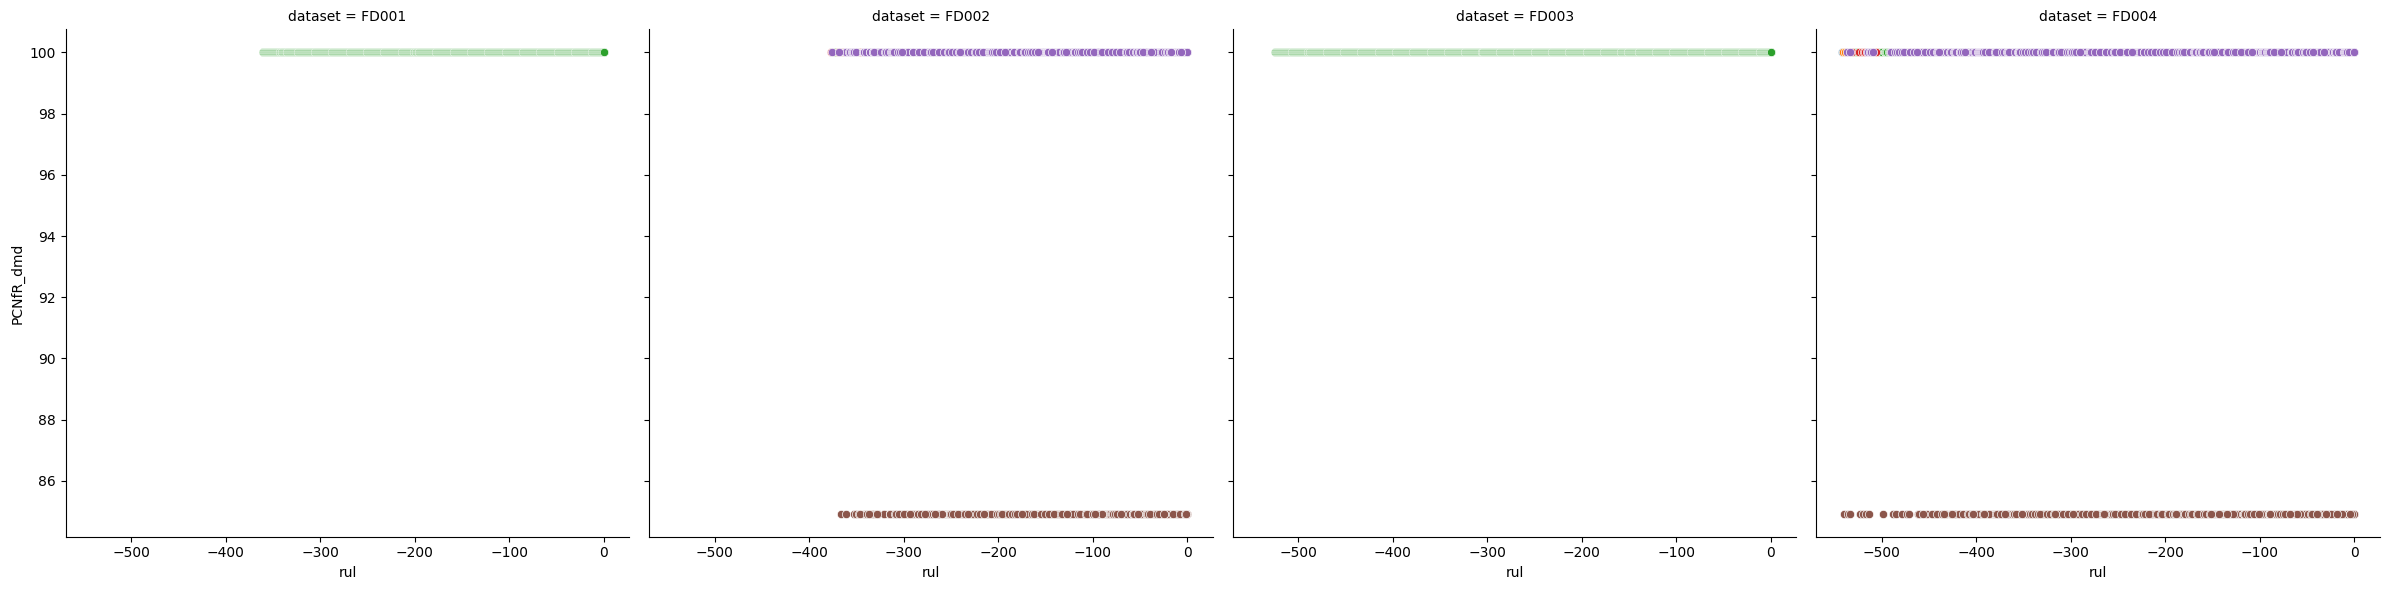

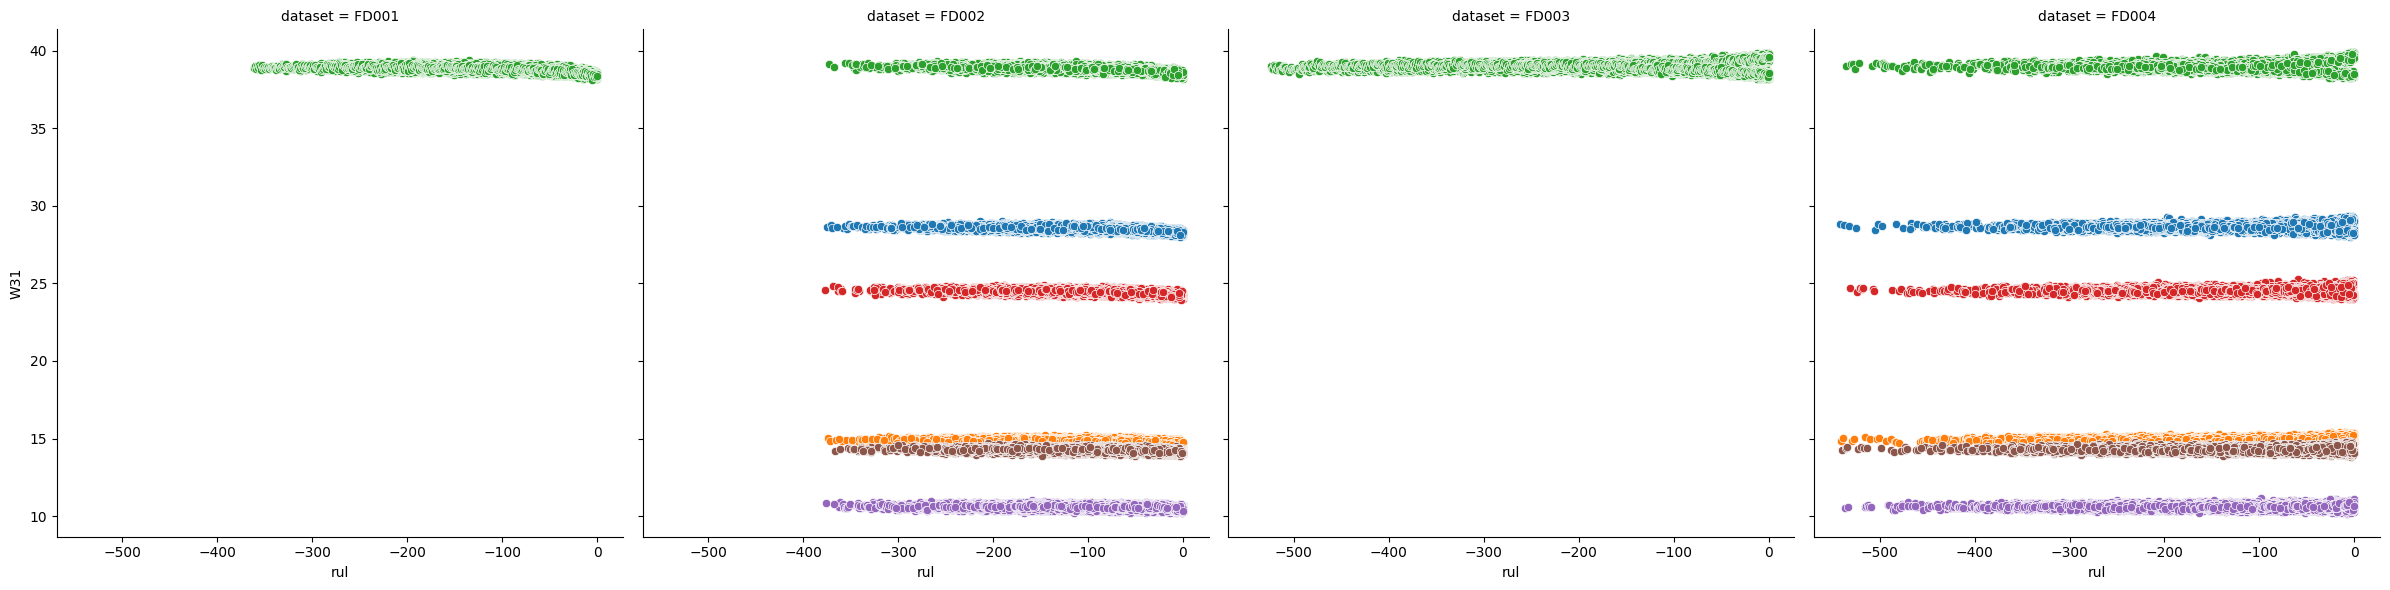

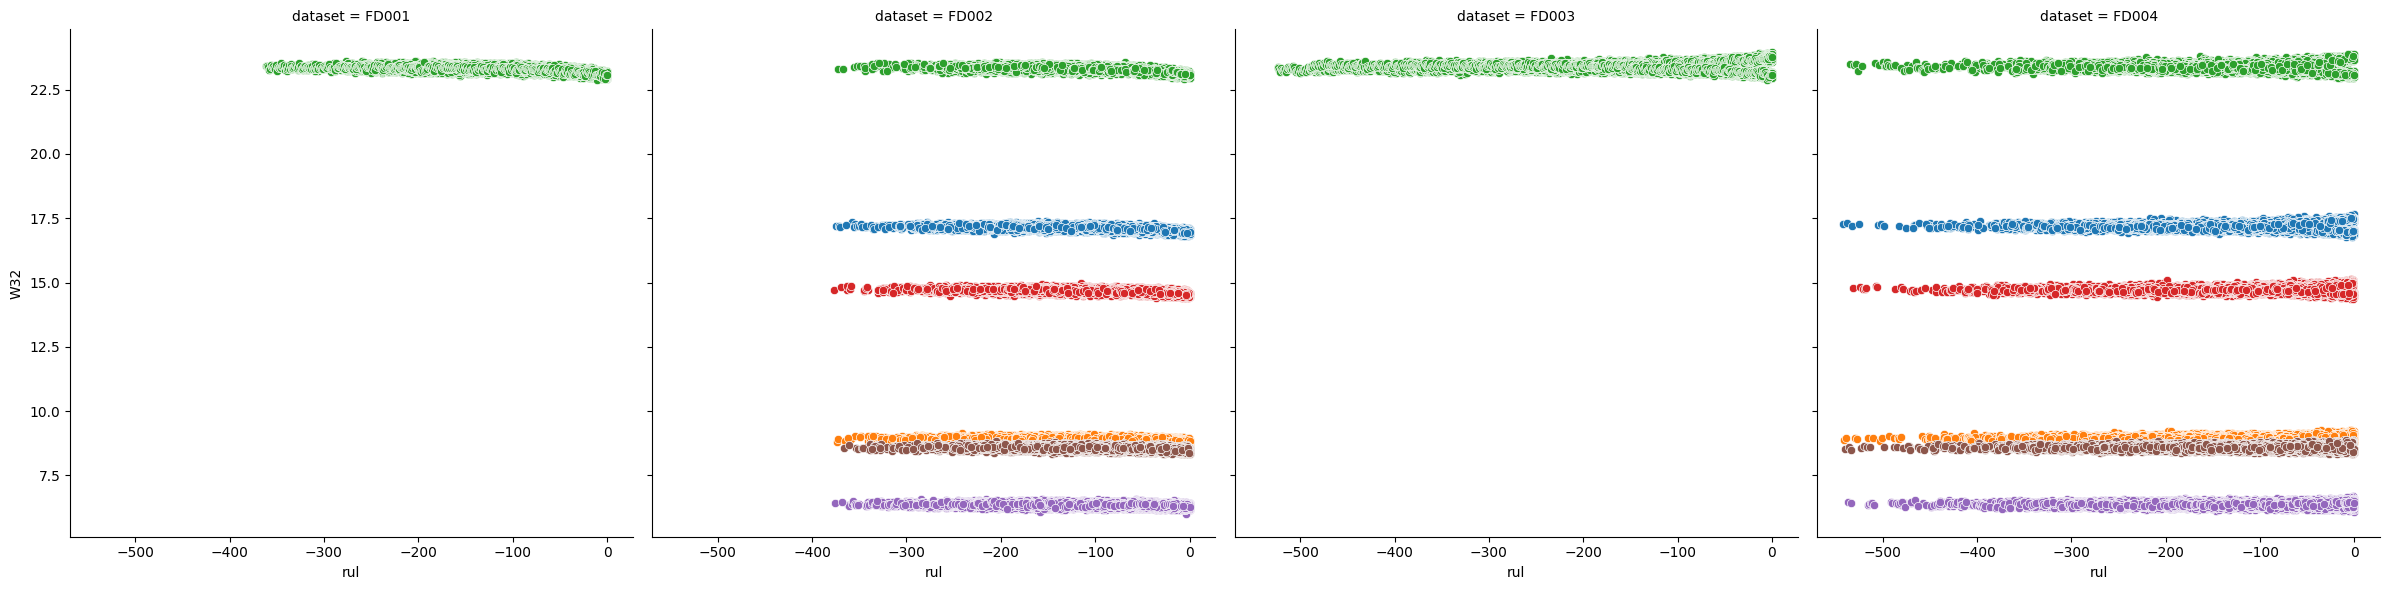

In [230]:
for sensor in sensors:    
    g = sns.FacetGrid(data = train, col = "dataset", hue= "condition",size=6)
    g.map(sns.scatterplot, "rul", sensor)
    plt.show()

One Hot Encoding for categorical variables: **DataSet** and **Category**

In [262]:
train = one_hot(train, 'dataset', ['FD001', 'FD002', 'FD003', 'FD004'])
train = one_hot(train, 'condition', ["c1","c2","c3","c4","c5","c6"])

In [263]:
train.head()

esn  cycles  opset1  opset2   TRA     T2    T24      T30      T50    P2  \
0    1       2  0.0019 -0.0003 100.0 518.67 642.15 1,591.82 1,403.14 14.62   
1    1       3 -0.0043  0.0003 100.0 518.67 642.35 1,587.99  1,404.2 14.62   
2    1       4  0.0007     0.0 100.0 518.67 642.35 1,582.79 1,401.87 14.62   
3    1       5 -0.0019 -0.0002 100.0 518.67 642.37 1,582.85 1,406.22 14.62   
4    1       6 -0.0043 -0.0001 100.0 518.67  642.1 1,584.47 1,398.37 14.62   

    P15    P30       Nf       Nc  epr  Ps30    phi      NRf      NRc    BPR  \
0 21.61 553.75 2,388.04 9,044.07  1.3 47.49 522.28 2,388.07 8,131.49 8.4318   
1 21.61 554.26 2,388.08 9,052.94  1.3 47.27 522.42 2,388.03 8,133.23 8.4178   
2 21.61 554.45 2,388.11 9,049.48  1.3 47.13 522.86 2,388.08 8,133.83 8.3682   
3 21.61  554.0 2,388.06 9,055.15  1.3 47.28 522.19 2,388.04  8,133.8 8.4294   
4 21.61 554.67 2,388.02 9,049.68  1.3 47.16 521.68 2,388.03 8,132.85 8.4108   

   farB  htBleed  Nf_dmd  PCNfR_dmd   W31     W32  max_cycles  rul  Class  \
0  0.03      392    2388      100.0  39.0 23.4236         192 -190      0   
1  0.03      390    2388      100.0 38.95 23.3442         192 -189      0   
2  0.03      392    2388      100.0 38.88 23.3739         192 -188      0   
3  0.03      393    2388      100.0  38.9 23.4044         192 -187      0   
4  0.03      391    2388      100.0 38.98 23.3669         192 -186      0   

   FD002  FD003  FD004  c2  c3  c4  c5  c6  
0    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0  
1    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0  
2    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0  
3    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0  
4    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0

In [232]:
X_variables = [
    'T24',
    'T30',
    'T50',
    'P30',
    'Nc',
    'epr',
    'Ps30',
    'phi',
    'NRc',
    'BPR', #ByPass Ratio
    'htBleed',
    'W31',
    'W32',
    'FD002', # dataset
    'FD003', # dataset
    'FD004', # dataset
    'c2', # condition 2
    'c3', # condition 3
    'c4', # condition 4
    'c5', # condition 5
    'c6', # condition 6
]

In [233]:
X = train[X_variables]
y = train["Class"]

In [3]:
#X_train_vars = sensors + ["condition", "dataset"]
#X_train_vars

['T2',
 'T24',
 'T30',
 'T50',
 'P2',
 'P15',
 'P30',
 'Nf',
 'Nc',
 'epr',
 'Ps30',
 'phi',
 'NRf',
 'NRc',
 'BPR',
 'farB',
 'htBleed',
 'Nf_dmd',
 'PCNfR_dmd',
 'W31',
 'W32',
 'condition',
 'dataset']

## Train test split 

In [234]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Classification

Data are continues so following classification methods will be tested:
1. Logit
2. Decision Tree
3. Random Forest
4. CatBoostClassifier
5. LightGBMClassifier


### Logistic Regression

Text(0.5, 427.9555555555555, 'Predicted label')

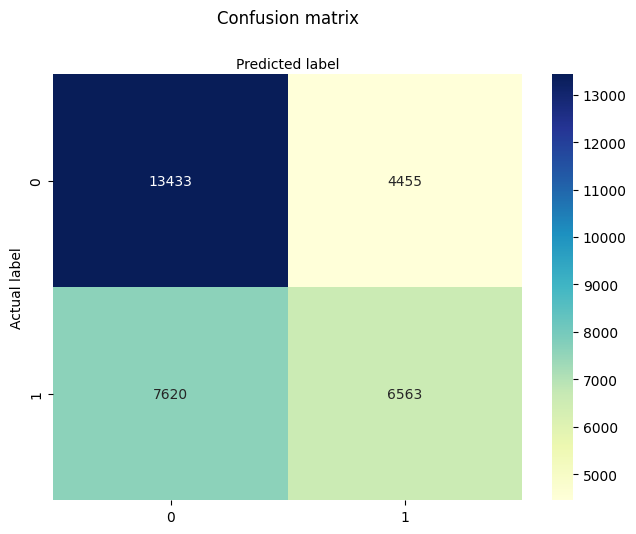

In [235]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_val)

cnf_matrix = metrics.confusion_matrix(y_val, y_pred)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



In [236]:
target_names = ['no damage', 'damaged']
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   no damage       0.64      0.75      0.69     17888
     damaged       0.60      0.46      0.52     14183

    accuracy                           0.62     32071
   macro avg       0.62      0.61      0.61     32071
weighted avg       0.62      0.62      0.62     32071



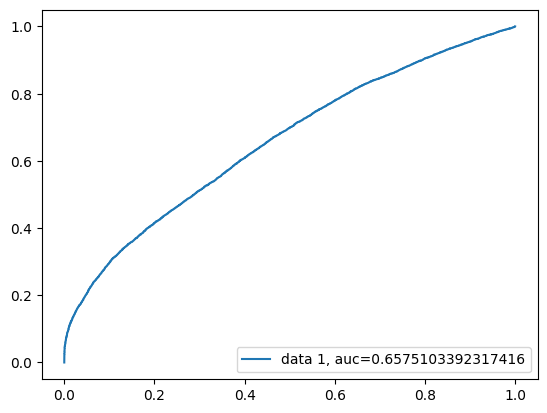

In [237]:
y_pred_proba = logreg.predict_proba(X_val)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Decision Tree

In [238]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_val)


In [239]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))


Accuracy: 0.778460291228836


In [240]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=12)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_val)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_val, y_pred))
print("F1:", metrics.f1_score(y_val, y_pred))
print("‘precision’:", metrics.precision_score(y_val, y_pred))



Accuracy: 0.8242025505908765
F1: 0.7851208171354525
‘precision’: 0.854417254251348


In [241]:
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   no damage       0.81      0.90      0.85     17888
     damaged       0.85      0.73      0.79     14183

    accuracy                           0.82     32071
   macro avg       0.83      0.81      0.82     32071
weighted avg       0.83      0.82      0.82     32071



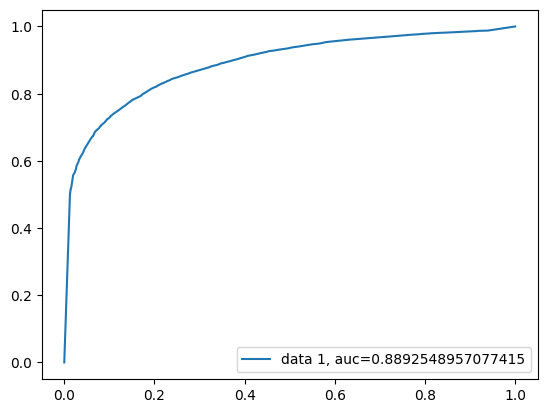

In [242]:
y_pred_proba = clf.predict_proba(X_val)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Random Forest

In [116]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [117]:
y_pred = rf.predict(X_val)

In [120]:
f1 = metrics.f1_score(y_val, y_pred)
print("f1_score:", f1)

f1_score: 0.8147671823580587


### Hyperparameter Tuning

In [121]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000161E0518AC0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000161E054BCD0>})

In [122]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 19, 'n_estimators': 254}


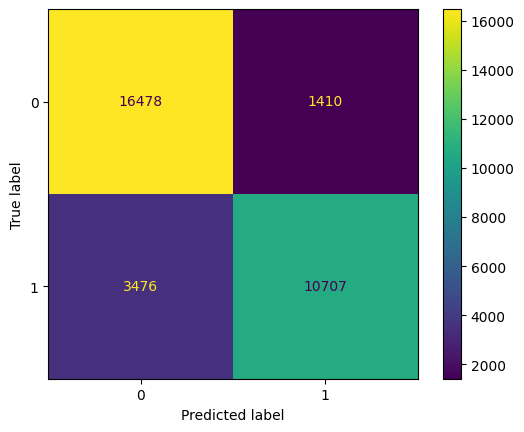

In [123]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_val)

# Create the confusion matrix
cm = confusion_matrix(y_val, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [215]:
y_pred = best_rf.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

Accuracy: 0.8476505253967759
Precision: 0.8836345630106462
Recall: 0.7549178594091518
F1: 0.8142205323193916


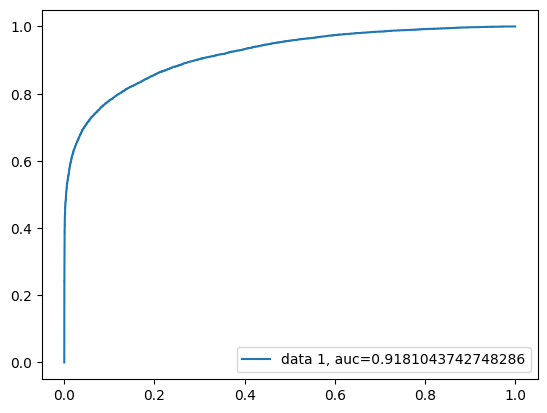

In [129]:
y_pred_proba = best_rf.predict_proba(X_val)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Feature Importance

<AxesSubplot:>

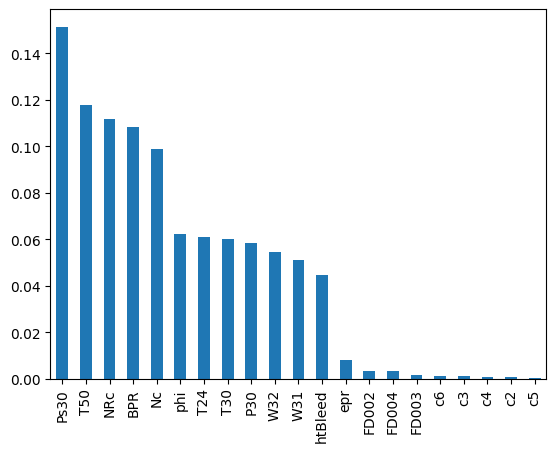

In [127]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()

### CatBoost Classifier

documentation: https://catboost.ai/en/docs/concepts/python-quickstart

In [243]:
cb = CatBoostClassifier(iterations=50,
                           depth=15,
                           learning_rate=0.2,
                           loss_function='Logloss',
                           verbose=False)
# train the model
cb.fit(X_train,y_train)
# make the prediction using the resulting model
preds_class = cb.predict(X_val)
preds_proba = cb.predict_proba(X_val)
print("class = ", preds_class)
print("proba = ", preds_proba)

0:	learn: 0.5820978	total: 4.01s	remaining: 3m 16s
1:	learn: 0.5142016	total: 7.14s	remaining: 2m 51s
2:	learn: 0.4725803	total: 10.4s	remaining: 2m 43s
3:	learn: 0.4438993	total: 13.4s	remaining: 2m 34s
4:	learn: 0.4232386	total: 16.8s	remaining: 2m 31s
5:	learn: 0.4092058	total: 20.1s	remaining: 2m 27s
6:	learn: 0.3980917	total: 22.9s	remaining: 2m 20s
7:	learn: 0.3894559	total: 25.7s	remaining: 2m 14s
8:	learn: 0.3820984	total: 28.5s	remaining: 2m 9s
9:	learn: 0.3800390	total: 28.6s	remaining: 1m 54s
10:	learn: 0.3751702	total: 31.2s	remaining: 1m 50s
11:	learn: 0.3708900	total: 33.8s	remaining: 1m 47s
12:	learn: 0.3669403	total: 36.4s	remaining: 1m 43s
13:	learn: 0.3642583	total: 39.2s	remaining: 1m 40s
14:	learn: 0.3593094	total: 42s	remaining: 1m 37s
15:	learn: 0.3565256	total: 44.8s	remaining: 1m 35s
16:	learn: 0.3536095	total: 48.4s	remaining: 1m 33s
17:	learn: 0.3513950	total: 51.5s	remaining: 1m 31s
18:	learn: 0.3503421	total: 51.6s	remaining: 1m 24s
19:	learn: 0.3488271	tota

In [244]:
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   no damage       0.81      0.90      0.85     17888
     damaged       0.85      0.73      0.79     14183

    accuracy                           0.82     32071
   macro avg       0.83      0.81      0.82     32071
weighted avg       0.83      0.82      0.82     32071



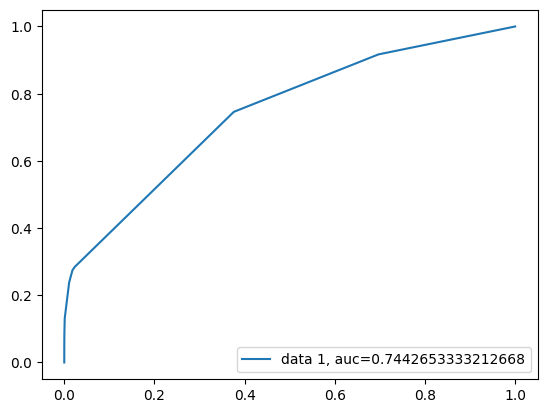

In [245]:
y_pred_proba = model.predict_proba(X_val)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### LightGBM Classifier

documentation:
 
    https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

    https://www.projectpro.io/recipes/use-lightgbm-classifier-and-regressor-in-python

In [269]:
ltb = LGBMClassifier()
ltb.fit(X_train, y_train)
print(); print(ltb)


LGBMClassifier()


In [264]:
X_train

T24      T30      T50    P30       Nc  epr  Ps30    phi      NRc  \
12551  642.49 1,588.64 1,406.08 553.04 9,062.86  1.3 47.43 521.83 8,136.05   
27458  555.97 1,372.17 1,128.45 194.47 8,346.23 1.02 41.78 183.04 8,062.26   
91293  642.75 1,590.97 1,418.24 552.95 9,063.85  1.3 47.64 520.62 8,140.83   
49186  549.56 1,342.87 1,130.42 138.19 8,319.73 1.02 41.84 130.61 8,093.12   
19356  642.06 1,587.62 1,393.99  553.6 9,071.33  1.3  47.4 521.92 8,152.78   
...       ...      ...      ...    ...      ...  ...   ...    ...      ...   
119879 607.59 1,481.26 1,267.26 334.11 8,732.32 1.07 44.56 315.14 8,067.36   
103694 536.38 1,256.14 1,047.41 175.14 8,002.72 0.94 36.42 164.56 7,870.93   
131932 643.51 1,599.03 1,421.51 565.02  9,104.6 1.31 47.99 532.74 8,178.07   
146867 607.46  1,489.2 1,252.87 335.09 8,712.72 1.08 44.31 314.66  8,049.4   
121958 643.76 1,599.18 1,421.33  551.9 9,080.73  1.3 48.02 519.89 8,162.76   

           BPR  htBleed   W31     W32  FD002  FD003  FD004  c2  c3  c4  c5  c6  
12551   8.4306      391 38.92 23.3497    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0  
27458   9.3256      334 15.01  8.9539    1.0    0.0    0.0 1.0 0.0 0.0 0.0 0.0  
91293    8.472      392 39.03 23.2826    0.0    1.0    0.0 0.0 1.0 0.0 0.0 0.0  
49186   9.3536      330 10.64  6.3741    1.0    0.0    0.0 0.0 0.0 0.0 1.0 0.0  
19356   8.4024      391 39.05 23.3651    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0  
...        ...      ...   ...     ...    ...    ...    ...  ..  ..  ..  ..  ..  
119879  9.2532      366 24.48 14.7157    0.0    0.0    1.0 0.0 0.0 1.0 0.0 0.0  
103694 10.8419      305 14.18  8.5093    0.0    0.0    1.0 0.0 0.0 0.0 0.0 1.0  
131932  8.2611      396 39.42 23.7641    0.0    0.0    1.0 0.0 1.0 0.0 0.0 0.0  
146867  9.2588      366 24.56 14.6727    0.0    0.0    1.0 0.0 0.0 1.0 0.0 0.0  
121958  8.5144      396 38.53 23.1657    0.0    0.0    1.0 0.0 1.0 0.0 0.0 0.0  

[128284 rows x 21 columns]

In [251]:
y_train

12551     0
27458     0
91293     1
49186     0
19356     0
         ..
119879    0
103694    0
131932    1
146867    0
121958    1
Name: Class, Length: 128284, dtype: int64

In [270]:
y_pred = ltb.predict(X_val)

In [140]:
print("Accuracy:", metrics.accuracy_score(y_val, y_pred))
print("F1:", metrics.f1_score(y_val, y_pred))
print("‘precision’:", metrics.precision_score(y_val, y_pred))

Accuracy: 0.8466527392348228
F1: 0.8141204928566029
‘precision’: 0.8773930753564155


In [266]:
train[X_variables]

T24      T30      T50    P30       Nc  epr  Ps30    phi      NRc  \
0      642.15 1,591.82 1,403.14 553.75 9,044.07  1.3 47.49 522.28 8,131.49   
1      642.35 1,587.99  1,404.2 554.26 9,052.94  1.3 47.27 522.42 8,133.23   
2      642.35 1,582.79 1,401.87 554.45 9,049.48  1.3 47.13 522.86 8,133.83   
3      642.37 1,582.85 1,406.22  554.0 9,055.15  1.3 47.28 522.19  8,133.8   
4       642.1 1,584.47 1,398.37 554.67 9,049.68  1.3 47.16 521.68 8,132.85   
...       ...      ...      ...    ...      ...  ...   ...    ...      ...   
160350 605.33 1,516.36 1,315.28 404.59 8,840.16 1.27 46.08 380.16 8,185.69   
160351 643.42 1,598.92 1,426.77 567.59 9,117.12 1.31 48.04 535.02 8,185.47   
160352 643.68 1,607.72 1,430.56 569.04 9,126.53 1.31 48.24 535.41 8,193.94   
160353 555.77 1,381.29 1,148.18 199.93 8,403.64 1.05 42.53 187.92 8,125.64   
160354 549.85 1,369.75 1,147.45 142.47 8,391.31 1.05  42.6 134.32 8,144.33   

          BPR  htBleed   W31     W32  FD002  FD003  FD004  c2  c3  c4  c5  c6  
0      8.4318      392  39.0 23.4236    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0  
1      8.4178      390 38.95 23.3442    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0  
2      8.3682      392 38.88 23.3739    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0  
3      8.4294      393  38.9 23.4044    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0  
4      8.4108      391 38.98 23.3669    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0  
...       ...      ...   ...     ...    ...    ...    ...  ..  ..  ..  ..  ..  
160350 8.4541      372 29.11 17.5234    0.0    0.0    1.0 0.0 0.0 0.0 0.0 0.0  
160351 8.2221      396 39.38 23.7151    0.0    0.0    1.0 0.0 1.0 0.0 0.0 0.0  
160352 8.2525      395 39.78  23.827    0.0    0.0    1.0 0.0 1.0 0.0 0.0 0.0  
160353 9.0515      337 15.26  9.0774    0.0    0.0    1.0 1.0 0.0 0.0 0.0 0.0  
160354 9.1207      333 10.66  6.4341    0.0    0.0    1.0 0.0 0.0 0.0 1.0 0.0  

[160355 rows x 21 columns]

In [273]:
train

esn  cycles  opset1  opset2   TRA     T2    T24      T30      T50  \
0         1       2  0.0019 -0.0003 100.0 518.67 642.15 1,591.82 1,403.14   
1         1       3 -0.0043  0.0003 100.0 518.67 642.35 1,587.99  1,404.2   
2         1       4  0.0007     0.0 100.0 518.67 642.35 1,582.79 1,401.87   
3         1       5 -0.0019 -0.0002 100.0 518.67 642.37 1,582.85 1,406.22   
4         1       6 -0.0043 -0.0001 100.0 518.67  642.1 1,584.47 1,398.37   
...     ...     ...     ...     ...   ...    ...    ...      ...      ...   
160350  249     251  9.9998    0.25 100.0 489.05 605.33 1,516.36 1,315.28   
160351  249     252  0.0028  0.0015 100.0 518.67 643.42 1,598.92 1,426.77   
160352  249     253  0.0029     0.0 100.0 518.67 643.68 1,607.72 1,430.56   
160353  249     254 35.0046    0.84 100.0 449.44 555.77 1,381.29 1,148.18   
160354  249     255  42.003    0.84 100.0  445.0 549.85 1,369.75 1,147.45   

          P2   P15    P30       Nf       Nc  epr  Ps30    phi      NRf  \
0      14.62 21.61 553.75 2,388.04 9,044.07  1.3 47.49 522.28 2,388.07   
1      14.62 21.61 554.26 2,388.08 9,052.94  1.3 47.27 522.42 2,388.03   
2      14.62 21.61 554.45 2,388.11 9,049.48  1.3 47.13 522.86 2,388.08   
3      14.62 21.61  554.0 2,388.06 9,055.15  1.3 47.28 522.19 2,388.04   
4      14.62 21.61 554.67 2,388.02 9,049.68  1.3 47.16 521.68 2,388.03   
...      ...   ...    ...      ...      ...  ...   ...    ...      ...   
160350 10.52 15.46 404.59 2,319.66 8,840.16 1.27 46.08 380.16 2,388.73   
160351 14.62 21.57 567.59 2,388.47 9,117.12 1.31 48.04 535.02 2,388.46   
160352 14.62 21.57 569.04 2,388.51 9,126.53 1.31 48.24 535.41 2,388.48   
160353  5.48  7.96 199.93 2,223.78 8,403.64 1.05 42.53 187.92 2,388.83   
160354  3.91  5.69 142.47 2,212.52 8,391.31 1.05  42.6 134.32 2,388.66   

            NRc    BPR  farB  htBleed  Nf_dmd  PCNfR_dmd   W31     W32  \
0      8,131.49 8.4318  0.03      392    2388      100.0  39.0 23.4236   
1      8,133.23 8.4178  0.03      390    2388      100.0 38.95 23.3442   
2      8,133.83 8.3682  0.03      392    2388      100.0 38.88 23.3739   
3       8,133.8 8.4294  0.03      393    2388      100.0  38.9 23.4044   
4      8,132.85 8.4108  0.03      391    2388      100.0 38.98 23.3669   
...         ...    ...   ...      ...     ...        ...   ...     ...   
160350 8,185.69 8.4541  0.03      372    2319      100.0 29.11 17.5234   
160351 8,185.47 8.2221  0.03      396    2388      100.0 39.38 23.7151   
160352 8,193.94 8.2525  0.03      395    2388      100.0 39.78  23.827   
160353 8,125.64 9.0515  0.02      337    2223      100.0 15.26  9.0774   
160354 8,144.33 9.1207  0.02      333    2212      100.0 10.66  6.4341   

        max_cycles  rul  Class  FD002  FD003  FD004  c2  c3  c4  c5  c6  \
0              192 -190      0    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0   
1              192 -189      0    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0   
2              192 -188      0    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0   
3              192 -187      0    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0   
4              192 -186      0    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0   
...            ...  ...    ...    ...    ...    ...  ..  ..  ..  ..  ..   
160350         255   -4      1    0.0    0.0    1.0 0.0 0.0 0.0 0.0 0.0   
160351         255   -3      1    0.0    0.0    1.0 0.0 1.0 0.0 0.0 0.0   
160352         255   -2      1    0.0    0.0    1.0 0.0 1.0 0.0 0.0 0.0   
160353         255   -1      1    0.0    0.0    1.0 1.0 0.0 0.0 0.0 0.0   
160354         255    0      1    0.0    0.0    1.0 0.0 0.0 0.0 1.0 0.0   

                class_proba  
0       0.08308128846315858  
1       0.05643344288360622  
2       0.06341139310608797  
3       0.08686432071107436  
4      0.034078190174722904  
...                     ...  
160350    0.989680754045828  
160351   0.9953225556303104  
160352   0.9817959729285092  
160353   0.9767858849146924  
160354    0.991171574635327  

[160355 rows x 38 columns]

In [271]:
train['class_proba'] = ltb.predict_proba(train[X_variables])[::,1]

In [254]:
y_pred_proba

array([0.5138308 , 0.92145648, 0.29531159, ..., 0.5138308 , 0.17524412,
       0.5138308 ])

cykle pracy na x, na y - prawdopod mniej lub 100 cykli do awarii


<AxesSubplot:xlabel='cycles', ylabel='class_proba'>

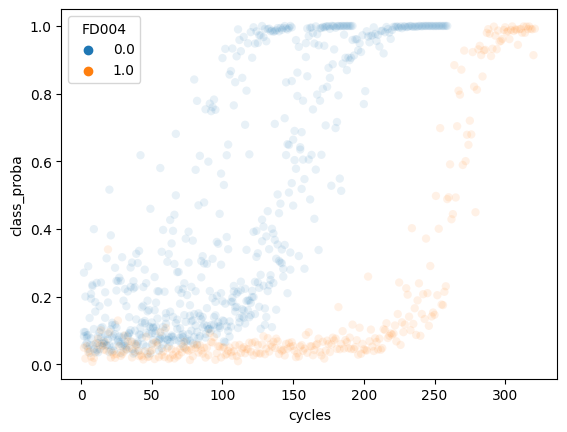

In [283]:
sns.scatterplot(data = train[train['esn']==1], x = "cycles", y = 'class_proba', alpha = 0.1, hue= "FD004")

In [255]:
X_val

T24      T30      T50    P30       Nc  epr  Ps30    phi      NRc  \
40419  608.44 1,495.88 1,269.57 333.87 8,732.35 1.07 45.07 313.97 8,051.93   
15356  643.42 1,601.28 1,429.56 550.81 9,049.71  1.3 48.04 520.04 8,124.53   
26127   555.4 1,362.31 1,116.49 194.78 8,358.89 1.02 41.64 183.51 8,079.26   
43242  555.36 1,354.87  1,118.3 194.59  8,364.4 1.02 41.82 183.93  8,078.5   
65091  549.53 1,346.86 1,121.77 138.57 8,321.37 1.02 42.09 130.34 8,084.51   
...       ...      ...      ...    ...      ...  ...   ...    ...      ...   
34240  550.01 1,363.04 1,134.23 138.01 8,322.81 1.02  42.6 130.03 8,072.58   
147355  537.0  1,263.2 1,048.79 175.09 8,006.62 0.94 36.73 163.84 7,871.66   
61073  549.61 1,358.17 1,127.41  138.1 8,313.76 1.02 42.32  130.7 8,078.97   
84008  642.74 1,586.46  1,396.6 554.18 9,060.86  1.3 47.05 522.36 8,142.78   
66930  549.83 1,353.01 1,136.38 138.32 8,330.44 1.02 42.07 130.42  8,093.4   

           BPR  htBleed   W31     W32  FD002  FD003  FD004  c2  c3  c4  c5  c6  
40419   9.2835      366 24.15 14.5492    1.0    0.0    0.0 0.0 0.0 1.0 0.0 0.0  
15356    8.535      397 38.55 23.0614    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0  
26127   9.3106      333 15.12  8.9347    1.0    0.0    0.0 1.0 0.0 0.0 0.0 0.0  
43242   9.3185      331 15.05  8.8119    1.0    0.0    0.0 1.0 0.0 0.0 0.0 0.0  
65091   9.3772      332  10.6  6.3575    1.0    0.0    0.0 0.0 0.0 0.0 1.0 0.0  
...        ...      ...   ...     ...    ...    ...    ...  ..  ..  ..  ..  ..  
34240    9.437      333 10.45   6.334    1.0    0.0    0.0 0.0 0.0 0.0 1.0 0.0  
147355 10.9013      306  13.9  8.6517    0.0    0.0    1.0 0.0 0.0 0.0 0.0 1.0  
61073   9.3748      331 10.59  6.3251    1.0    0.0    0.0 0.0 0.0 0.0 1.0 0.0  
84008    8.414      393 39.04 23.2577    0.0    1.0    0.0 0.0 1.0 0.0 0.0 0.0  
66930   9.3648      330 10.62  6.2485    1.0    0.0    0.0 0.0 0.0 0.0 1.0 0.0  

[32071 rows x 21 columns]

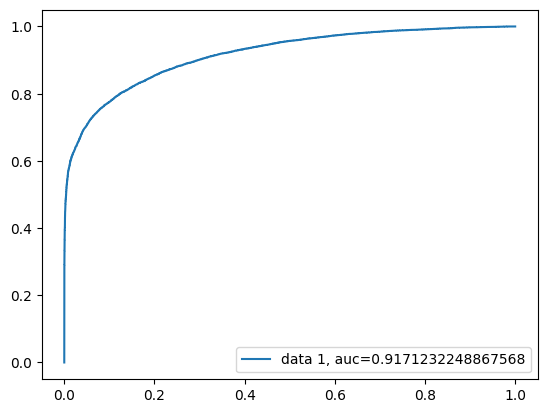

In [284]:
y_pred_proba = ltb.predict_proba(X_val)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Text(0.5, 427.9555555555555, 'Predicted label')

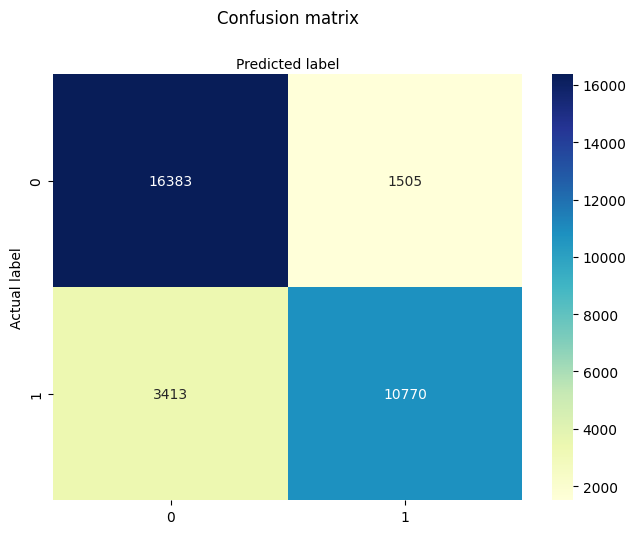

In [143]:
cnf_matrix = metrics.confusion_matrix(y_val, y_pred)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Krzywa Precision-Recall

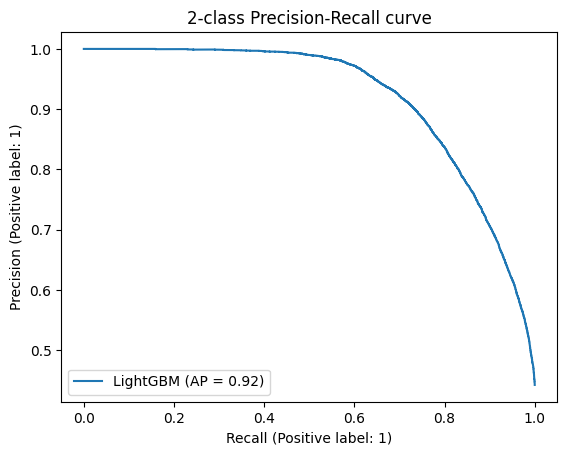

In [148]:


display = PrecisionRecallDisplay.from_estimator(
    ltb, X_val, y_val, name="LightGBM"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

### SHAP Explainer

https://www.kaggle.com/code/ritzig/classification-feature-selection-shap-tutorial

In [162]:

feature_importances = pd.Series(ltb.feature_importances_, index=X_train.columns)

print('Score of LightGBM model on validation split\n',ltb.score(X_val,y_val))

Score of LightGBM model on validation split
 0.8466527392348228


In [163]:
# creating an explainer for our model
explainer = shap.TreeExplainer(ltb) # we only need to pass our  fitted model to tree explainer. 
                                    #No background dataset in 'data' argument required for tree models as it
                                    #is automatically received through the model tree object.

# finding out the shap values using the explainer
shap_values = explainer.shap_values(X_train)

# Expected/Base/Reference value = the value that would be predicted if we didn’t know any features of the current output”
print('Expected Value:', explainer.expected_value)

Expected Value: [-0.10160741077446482, 0.10160741077446482]


In [164]:
# Shap Values for class =0 that is  class
print("Shap Values for 'Prince Range 0' class")
pd.DataFrame(shap_values[0],columns=X_train.columns).head()

Shap Values for 'Prince Range 0' class


T24                   T30                  T50  \
0 -0.10166521451245616  -0.07284842276513873 -0.23013526696545925   
1    0.098683647102555   0.12830731796170441   0.1553875689016224   
2 -0.18139940099542984  -0.09707022916773451  -0.8928276433200742   
3  0.24473279721280405     0.432825837382134   0.0695559751906243   
4 -0.05358899103256666 -0.015023794287455127  0.06325030924867539   

                   P30                  Nc                     epr  \
0  0.17094657702263846 -0.4209525797118402   -0.006097352141910635   
1 -0.20046610210514965 0.12114718697002656 -0.00013948626286634994   
2  0.12852633110927267 -0.4173976232941725   -0.006645290201347771   
3 -0.29022643856613245  0.5946219123438287     -0.0145577027790217   
4  0.27037389460853467 -0.6415830263616809   -0.006679177873316828   

                  Ps30                   phi                  NRc  \
0 -0.49518742327635357   0.32287016244533673 -0.03278586693770234   
1    1.097447753166685  -0.15534296394317146   0.6090153349149138   
2  -0.8185890212904848 -0.029712182585175176 -0.16722970540716753   
3   0.7647737641800808  -0.03243828485608834    0.177141178193291   
4  -0.4452428144086526   0.36261829284772235  -0.6067918671621781   

                  BPR               htBleed                 W31  \
0  0.9727593591699516 -0.015343334927210463  0.6095174463137603   
1  0.2640869797673347   0.04474966903691851 -0.2822396166468773   
2 0.24395066060467271  -0.05612073341829023  0.5509797374208275   
3 0.19230070335006894    0.1900297337806563 -0.3037303137152652   
4  1.1234956654366792    0.0014762162755878  0.9193446454958065   

                   W32                  FD002                 FD003  \
0   0.4792157587792797  0.0005328912448025092  0.012628820778914744   
1  -0.2629049123059823   0.013405321461711448  -0.01050669319171049   
2  0.15086656719329156   0.001112759943340185 0.0014320974749521076   
3 -0.27640635628385285   0.016695627194183393  -0.01050669319171049   
4   0.5995391718115982 -0.0016602794731601775   0.04414475866201499   

                   FD004                    c2  c3  c4  c5  c6  
0 0.00013425588555998174 0.0018300660307600447 0.0 0.0 0.0 0.0  
1  0.0009487985981041288  -0.01111567526789468 0.0 0.0 0.0 0.0  
2  0.0005120276685881201  0.003959621479608743 0.0 0.0 0.0 0.0  
3  0.0009487985981041288 0.0019821755180902596 0.0 0.0 0.0 0.0  
4  0.0002381491598765893  0.001123100425967728 0.0 0.0 0.0 0.0

In [165]:
#Force Plot for a single observation for a single class 0
shap.initjs()
shap.force_plot(explainer.expected_value[0],
shap_values[0][0,:], X_train.iloc[0])

In [167]:
#Force Plot for a single observation for a single class 3
shap.initjs()
shap.force_plot(explainer.expected_value[1],
shap_values[1][0,:], X_train.iloc[0,:])

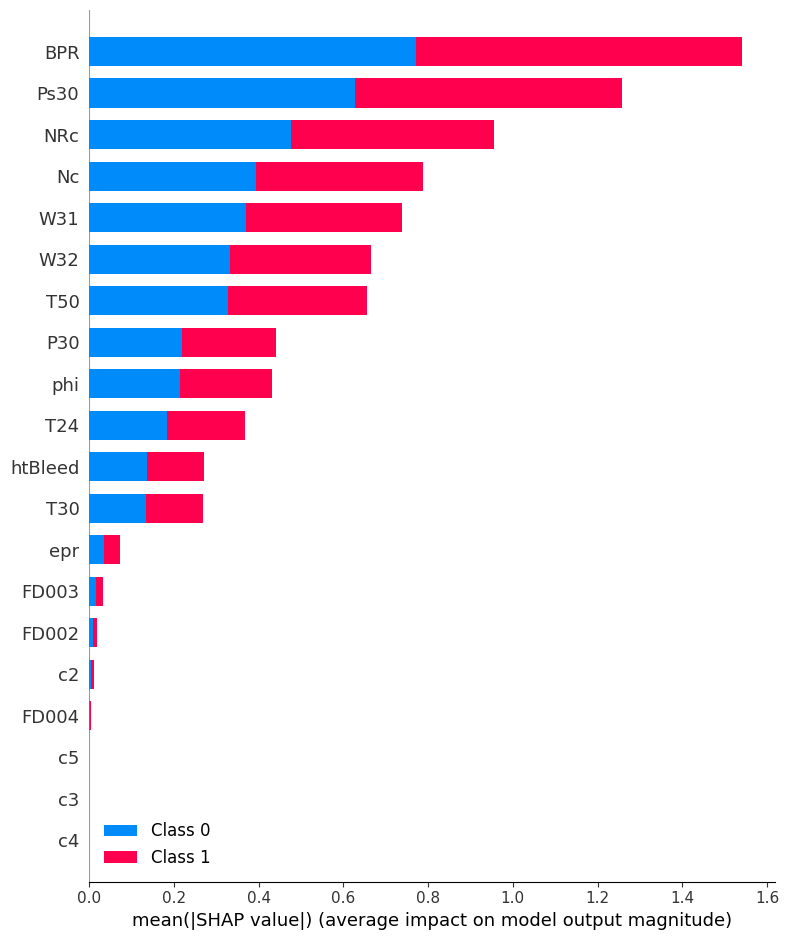

In [169]:
shap.initjs()
shap.summary_plot(shap_values, X_val)

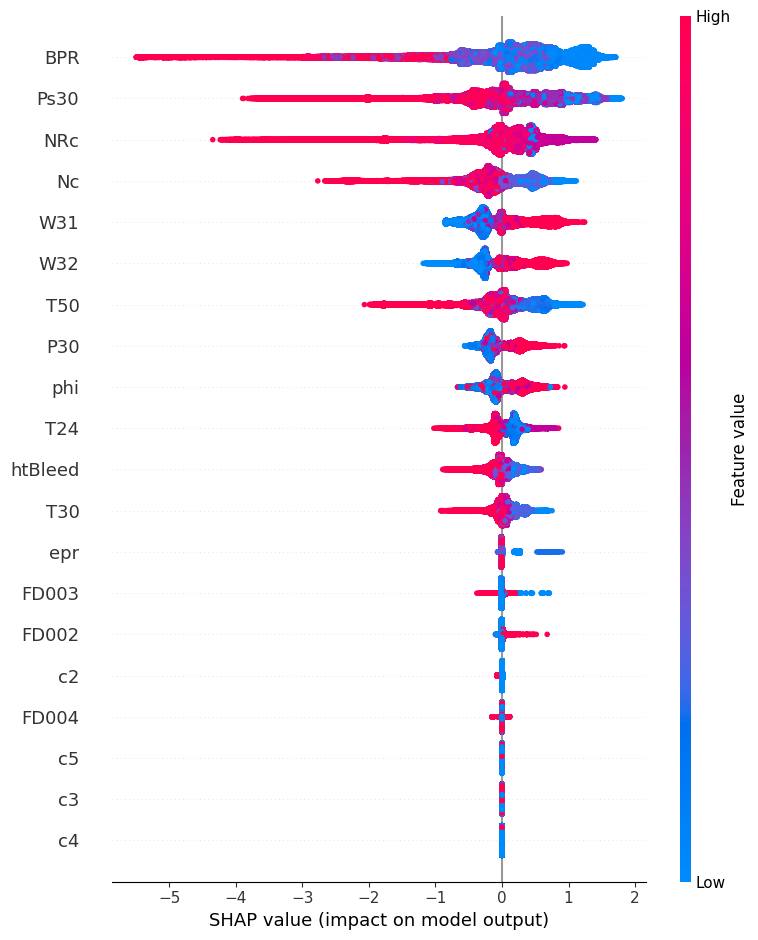

In [170]:
shap.initjs()
shap.summary_plot(shap_values[0], X_train)

Transformacja logarytmiczna zmiennych 

In [179]:
X_train_log = X_train[['T24', 'T30', 'T50', 'P30', 'Nc', 'epr', 'Ps30', 'phi', 'BPR', 'htBleed', 'W31','W32']]



In [186]:
cols = X_train_log.columns.tolist()

In [192]:
def col_log(row):
    return np.log(row)
        

In [193]:
X_train_log = X_train_log.apply(col_log)

In [194]:
X_train_log

T24               T30               T50  \
12551   6.465351252445917 7.370633583285284  7.24856096975619   
27458   6.320714335960328 7.224148707315568  7.02860028867434   
91293   6.465755846145999 7.372099172094641 7.257171945238755   
49186   6.309117958055747 7.202564393625032 7.030344524065889   
19356   6.464681757266964 7.369991318461206 7.239925417693591   
...                   ...               ...               ...   
119879  6.409500312389999 7.300648355915506 7.144612368424106   
103694  6.284842865104642 7.135798805784539 6.954075729250642   
131932 6.4669375669309765 7.377152474384034 7.259474965888681   
146867  6.409286329425518 7.305994341998562 7.133192198515955   
121958  6.467325985837878  7.37724627685486 7.259348331959061   

                      P30                Nc                  epr  \
12551  6.3154303316370095  9.11194002251188  0.26236426446749106   
27458   5.270277909516791  9.02956521888345  0.01980262729617973   
91293   6.315267581521369  9.11204925358591  0.26236426446749106   
49186   4.928629549815393 9.026385081365602  0.01980262729617973   
19356  6.3164424043034595   9.1128741696247  0.26236426446749106   
...                   ...               ...                  ...   
119879  5.811470280073118 9.074786363814663  0.06765864847381486   
103694 5.1655856540940785  8.98753676287507 -0.06187540371808753   
131932 6.3368611287500265 9.116535059291127   0.2700271372130602   
146867  5.814399152459731 9.072539305826016   0.0769610411361284   
121958 6.3133668704454555 9.113909864839487  0.26236426446749106   

                     Ps30                phi                BPR  \
12551    3.85925493988949 6.2573418643424015 2.1318679438582127   
27458  3.7324177561284198  5.209704708191433 2.2327633066234855   
91293  3.8636727444870993  6.255020409033453 2.1367666082991055   
49186  3.7338528197566676 4.8722157835894295 2.2357612959347897   
19356   3.858622228701031  6.257514319432649 2.1285173793264285   
...                   ...                ...                ...   
119879 3.7968365956190286  5.753016984533899 2.2249694376447784   
103694  3.595118074299462  5.103275245344702 2.3834182574050926   
131932 3.8709926558701544   6.27803350027229 2.1115577505791276   
146867 3.7912103852113983  5.751492690812277  2.225574450627797   
121958 3.8716175907931074  6.253617250736518 2.1417588477446974   

                 htBleed                W31                W32  
12551  5.968707559985366 3.6615082573178044 3.1505841360666316  
27458  5.811140992976701 2.7087166456453704 2.1920891915634226  
91293  5.971261839790462 3.6643305811925235 3.1477063004758574  
49186  5.799092654460526 2.3646204839134985 1.8522429046075657  
19356  5.968707559985366  3.664842876285695 3.1512434560490727  
...                  ...                ...                ...  
119879 5.902633333401366 3.1978564576441255 2.6889149510602817  
103694 5.720311776607412 2.6518325211039815  2.141159683032846  
131932 5.981414211254481  3.674273301724574 3.1681760385304245  
146867 5.902633333401366 3.2011191032789417  2.685988624299691  
121958 5.981414211254481 3.6514371586380663  3.142672736413352  

[128284 rows x 12 columns]

In [201]:
X_val_log = X_val[cols]

In [202]:
X_val_log = X_val_log.apply(col_log)

# X test to be transformed as well!

### LightGMB on loged data

In [212]:
ltb = LGBMClassifier(num_leaves= 100,
                    max_depth=15,
                    learning_rate= 0.2)
ltb.fit(X_train_log, y_train)

LGBMClassifier(learning_rate=0.2, max_depth=15, num_leaves=100)

In [213]:
y_pred = ltb.predict(X_val_log)

In [214]:
print("Accuracy:", metrics.accuracy_score(y_val, y_pred))
print("F1:", metrics.f1_score(y_val, y_pred))
print("‘precision’:", metrics.precision_score(y_val, y_pred))

Accuracy: 0.8415390851548128
F1: 0.8085298771757967
‘precision’: 0.868193219516142


### RUL to be established only in group of ESNs that reveils different behavior due to approaching Failure

Approaches to be tested: RUL as continoues y calculated for every row apart with Linear Reg, Regression Tree, Catoost Regressor, XGBoost, LightGBM

In [ ]:
X_train, X_val, y_train, y_val

In [219]:
lead_time = -100

def make_y(row):
    return 1 if row["rul"] > lead_time else 0

train["Class"] = train.apply(make_y, axis = 1)
train

esn  cycles  opset1  opset2   TRA     T2    T24      T30      T50  \
0         1       2  0.0019 -0.0003 100.0 518.67 642.15 1,591.82 1,403.14   
1         1       3 -0.0043  0.0003 100.0 518.67 642.35 1,587.99  1,404.2   
2         1       4  0.0007     0.0 100.0 518.67 642.35 1,582.79 1,401.87   
3         1       5 -0.0019 -0.0002 100.0 518.67 642.37 1,582.85 1,406.22   
4         1       6 -0.0043 -0.0001 100.0 518.67  642.1 1,584.47 1,398.37   
...     ...     ...     ...     ...   ...    ...    ...      ...      ...   
160350  249     251  9.9998    0.25 100.0 489.05 605.33 1,516.36 1,315.28   
160351  249     252  0.0028  0.0015 100.0 518.67 643.42 1,598.92 1,426.77   
160352  249     253  0.0029     0.0 100.0 518.67 643.68 1,607.72 1,430.56   
160353  249     254 35.0046    0.84 100.0 449.44 555.77 1,381.29 1,148.18   
160354  249     255  42.003    0.84 100.0  445.0 549.85 1,369.75 1,147.45   

          P2   P15    P30       Nf       Nc  epr  Ps30    phi      NRf  \
0      14.62 21.61 553.75 2,388.04 9,044.07  1.3 47.49 522.28 2,388.07   
1      14.62 21.61 554.26 2,388.08 9,052.94  1.3 47.27 522.42 2,388.03   
2      14.62 21.61 554.45 2,388.11 9,049.48  1.3 47.13 522.86 2,388.08   
3      14.62 21.61  554.0 2,388.06 9,055.15  1.3 47.28 522.19 2,388.04   
4      14.62 21.61 554.67 2,388.02 9,049.68  1.3 47.16 521.68 2,388.03   
...      ...   ...    ...      ...      ...  ...   ...    ...      ...   
160350 10.52 15.46 404.59 2,319.66 8,840.16 1.27 46.08 380.16 2,388.73   
160351 14.62 21.57 567.59 2,388.47 9,117.12 1.31 48.04 535.02 2,388.46   
160352 14.62 21.57 569.04 2,388.51 9,126.53 1.31 48.24 535.41 2,388.48   
160353  5.48  7.96 199.93 2,223.78 8,403.64 1.05 42.53 187.92 2,388.83   
160354  3.91  5.69 142.47 2,212.52 8,391.31 1.05  42.6 134.32 2,388.66   

            NRc    BPR  farB  htBleed  Nf_dmd  PCNfR_dmd   W31     W32  \
0      8,131.49 8.4318  0.03      392    2388      100.0  39.0 23.4236   
1      8,133.23 8.4178  0.03      390    2388      100.0 38.95 23.3442   
2      8,133.83 8.3682  0.03      392    2388      100.0 38.88 23.3739   
3       8,133.8 8.4294  0.03      393    2388      100.0  38.9 23.4044   
4      8,132.85 8.4108  0.03      391    2388      100.0 38.98 23.3669   
...         ...    ...   ...      ...     ...        ...   ...     ...   
160350 8,185.69 8.4541  0.03      372    2319      100.0 29.11 17.5234   
160351 8,185.47 8.2221  0.03      396    2388      100.0 39.38 23.7151   
160352 8,193.94 8.2525  0.03      395    2388      100.0 39.78  23.827   
160353 8,125.64 9.0515  0.02      337    2223      100.0 15.26  9.0774   
160354 8,144.33 9.1207  0.02      333    2212      100.0 10.66  6.4341   

       dataset  max_cycles  rul  condition  Class  
0        FD001         192 -190          2      0  
1        FD001         192 -189          2      0  
2        FD001         192 -188          2      0  
3        FD001         192 -187          2      0  
4        FD001         192 -186          2      0  
...        ...         ...  ...        ...    ...  
160350   FD004         255   -4          0      1  
160351   FD004         255   -3          2      1  
160352   FD004         255   -2          2      1  
160353   FD004         255   -1          1      1  
160354   FD004         255    0          4      1  

[160355 rows x 31 columns]

In [220]:
RUL_train = train[train["Class"] == 1]
RUL_train

esn  cycles  opset1  opset2   TRA     T2    T24      T30      T50  \
91        1      93  0.0032  0.0002 100.0 518.67 642.85 1,593.74 1,408.48   
92        1      94 -0.0021  0.0002 100.0 518.67 642.45 1,583.27 1,404.94   
93        1      95  0.0019  0.0003 100.0 518.67 642.86  1,577.6  1,410.1   
94        1      96 -0.0034  0.0001 100.0 518.67 642.19 1,584.07 1,395.16   
95        1      97  0.0035 -0.0003 100.0 518.67 642.07 1,595.77 1,407.81   
...     ...     ...     ...     ...   ...    ...    ...      ...      ...   
160350  249     251  9.9998    0.25 100.0 489.05 605.33 1,516.36 1,315.28   
160351  249     252  0.0028  0.0015 100.0 518.67 643.42 1,598.92 1,426.77   
160352  249     253  0.0029     0.0 100.0 518.67 643.68 1,607.72 1,430.56   
160353  249     254 35.0046    0.84 100.0 449.44 555.77 1,381.29 1,148.18   
160354  249     255  42.003    0.84 100.0  445.0 549.85 1,369.75 1,147.45   

          P2   P15    P30       Nf       Nc  epr  Ps30    phi      NRf  \
91     14.62 21.61 554.07 2,388.07 9,047.87  1.3 47.46 521.43 2,388.08   
92     14.62 21.61 553.86 2,388.15 9,045.83  1.3 47.48 521.61 2,388.07   
93     14.62 21.61 553.91 2,388.02 9,048.85  1.3 47.38 521.92 2,388.02   
94     14.62 21.61 553.34 2,388.07 9,048.71  1.3 47.39 521.66 2,388.06   
95     14.62 21.61  553.4 2,388.09  9,046.1  1.3 47.46 521.67 2,388.06   
...      ...   ...    ...      ...      ...  ...   ...    ...      ...   
160350 10.52 15.46 404.59 2,319.66 8,840.16 1.27 46.08 380.16 2,388.73   
160351 14.62 21.57 567.59 2,388.47 9,117.12 1.31 48.04 535.02 2,388.46   
160352 14.62 21.57 569.04 2,388.51 9,126.53 1.31 48.24 535.41 2,388.48   
160353  5.48  7.96 199.93 2,223.78 8,403.64 1.05 42.53 187.92 2,388.83   
160354  3.91  5.69 142.47 2,212.52 8,391.31 1.05  42.6 134.32 2,388.66   

            NRc    BPR  farB  htBleed  Nf_dmd  PCNfR_dmd   W31     W32  \
91     8,133.15  8.421  0.03      392    2388      100.0 38.86 23.2477   
92      8,132.4 8.4524  0.03      393    2388      100.0 38.85 23.3758   
93     8,131.63 8.4575  0.03      394    2388      100.0 38.76 23.3269   
94     8,130.69 8.4311  0.03      392    2388      100.0 38.88 23.3255   
95     8,128.74 8.4105  0.03      392    2388      100.0 39.01 23.2963   
...         ...    ...   ...      ...     ...        ...   ...     ...   
160350 8,185.69 8.4541  0.03      372    2319      100.0 29.11 17.5234   
160351 8,185.47 8.2221  0.03      396    2388      100.0 39.38 23.7151   
160352 8,193.94 8.2525  0.03      395    2388      100.0 39.78  23.827   
160353 8,125.64 9.0515  0.02      337    2223      100.0 15.26  9.0774   
160354 8,144.33 9.1207  0.02      333    2212      100.0 10.66  6.4341   

       dataset  max_cycles  rul  condition  Class  
91       FD001         192  -99          2      1  
92       FD001         192  -98          2      1  
93       FD001         192  -97          2      1  
94       FD001         192  -96          2      1  
95       FD001         192  -95          2      1  
...        ...         ...  ...        ...    ...  
160350   FD004         255   -4          0      1  
160351   FD004         255   -3          2      1  
160352   FD004         255   -2          2      1  
160353   FD004         255   -1          1      1  
160354   FD004         255    0          4      1  

[70900 rows x 31 columns]

In [222]:
RUL_train = one_hot(train, 'dataset', ['FD001', 'FD002', 'FD003', 'FD004'])
RUL_train = one_hot(train, 'condition', ["c1","c2","c3","c4","c5","c6"])

In [221]:
X_variables = [
    'T24',
    'T30',
    'T50',
    'P30',
    'Nc',
    'epr',
    'Ps30',
    'phi',
    'NRc',
    'BPR', #ByPass Ratio
    'htBleed',
    'W31',
    'W32',
    'FD002', # dataset
    'FD003', # dataset
    'FD004', # dataset
    'c2', # condition 2
    'c3', # condition 3
    'c4', # condition 4
    'c5', # condition 5
    'c6', # condition 6
]

In [224]:
X = RUL_train[X_variables]
#y = RUL_train["rul"]

KeyError: "['FD002', 'FD003', 'FD004'] not in index"